In [1]:
import os, sys, re
from functools import partial

import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import shap

import dproc, sgml, sgutil

print(sys.version)
for i in [scipy, sklearn, mpl, sns, np, pd, pl, cb, lgb, xgb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
scipy 1.13.0
sklearn 1.4.2
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
pandas 2.2.2
polars 1.12.0
catboost 1.2.5
lightgbm 4.3.0
xgboost 2.1.2
shap 0.46.0


# Data acquirement

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e12
    !mkdir data
    !unzip playground-series-s4e12.zip -d data
    !rm playground-series-s4e12.zip
    !kaggle datasets download -d schran/insurance-premium-prediction
    !unzip insurance-premium-prediction.zip
    !mv "Insurance Premium Prediction Dataset.csv" "data/org.csv"
    !rm insurance-premium-prediction.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    features = \
"""1. Age: Age of the insured individual (Numerical)
2. Gender: Gender of the insured individual (Categorical: Male, Female)
3. Annual Income: Annual income of the insured individual (Numerical, skewed)
4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
5. Number of Dependents: Number of dependents (Numerical, with missing values)
6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
8. Health Score: A score representing the health status (Numerical, skewed)
9. Location: Type of location (Categorical: Urban, Suburban, Rural)
10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
11. Previous Claims: Number of previous claims made (Numerical, with outliers)
12. Vehicle Age: Age of the vehicle insured (Numerical)
13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
17. Customer Feedback: Short feedback comments from customers (Text)
18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)"""
    df_var = pd.DataFrame(
        [pd.Series(re.findall("[0-9]+. (?P<name>[^:]+): (?P<desc>.+)", i)[0], index=['name', 'Description']) for i in features.split('\n') if len(i) != 0],
    ).set_index('name')
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org']
    ])
    pl_type = dproc.get_type_pl(
        df_type, 
        {
            'Smoking Status': pl.Categorical, 'Gender': pl.Categorical, 'Marital Status': pl.Categorical, 'Education Level': pl.Categorical,
            'Occupation': pl.Categorical, 'Location': pl.Categorical, 'Policy Type': pl.Categorical, 'Smoking Status': pl.Categorical,
            'Exercise Frequency': pl.Categorical, 'Property Type': pl.Categorical
        }
    )
    df_var = pd.concat([
        df_var,
        df_type,
        pd.Series(pl_type, name = 'pl_type')
    ], axis=1)
    df_var
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    pl.scan_csv('data/org.csv', schema_overrides = pl_type).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
    !rm data/org.csv
df_var = pd.read_pickle(files['var_pkl'])
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])

In [5]:
ord_list = [
    ('Education Level', {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}),
    ('Location', {"Rural": 0, "Suburban": 1, "Urban": 2}),
    ('Policy Type', {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}),
    ('Exercise Frequency', {'Daily': 0, 'Weekly': 1, 'Monthly': 2, 'Rarely': 3}),
    ('Customer Feedback', {'Poor': 0, 'Average': 1, 'Good': 2}),
]

proc_list=[
    (i, pl.col(i).cast(pl.String).replace(d).cast(pl.Int8), ['{}: {}'.format(k, v) for k, v in d.items()])
    for i, d in ord_list 
]
proc_list += [
    ('Smoking Status', (pl.col('Smoking Status') == 'Yes').cast(pl.Int8), '0: No, 1: Yes'),
    ('Gender', (pl.col('Gender') == 'Male').cast(pl.Int8), '0: Female, 1: Male')
]

In [6]:
df_train, df_var_proc = dproc.apply_with_columns(df_train, proc_list, 'org')
df_var = pd.concat([
    df_var,
    df_var_proc
], axis = 0).assign(
    src = lambda x: x['src'].fillna('org')
).groupby(level=0).last()
df_test = dproc.apply_with_columns(df_test, proc_list)
df_org = dproc.apply_with_columns(df_org, proc_list)

df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

pd_vars= dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

In [7]:
X_bool = ['Gender', 'Smoking Status']
X_ord = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Customer Feedback', 'Weekday', 'Day', 'Year', 'Month']
X_nom = ['Marital Status', 'Occupation', 'Property Type']
X_cat = X_bool + X_ord + X_nom
X_num = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age']

In [8]:
df_train = pd_vars.put_proc('org', df_train, [(lambda x: pd.to_datetime(x['Policy Start Date']), 'Start date of the insurance policy')])

In [9]:
def date_proc(x):
    return pd.concat([
        x['Policy Start Date'].dt.year.astype('category').rename('Year'),
        x['Policy Start Date'].dt.month.astype('category').rename('Month'),
        x['Policy Start Date'].dt.day.astype('category').rename('Day'),
        x['Policy Start Date'].dt.weekday.astype('category').rename('Weekday'),
        x['Policy Start Date'].dt.dayofyear.rename('DoY'),
    ], axis=1)
df_train = pd_vars.put_proc('date_proc', df_train, [
    (date_proc, {'Year': 'Policy Start Date의 Year',
                'Month': 'Policy Start Date 의 Month',
                'Day': 'Policy Start Date의 Day', 
                'Weekday': 'Policy Start Date의 Weekday',
                'DoY': 'Policy Start Date의 Day of Year'})
    ])
df_test, _ = pd_vars.procs_all(df_test)
df_org , _= pd_vars.procs_all(df_org)
pd_vars.save()

In [10]:
df_train['Premium Amount_l'] = np.log(df_train['Premium Amount'])
target = 'Premium Amount_l'

In [11]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    if df[col].nunique() > 31:
        df.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
            x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
        ).rename(columns = {'x': col}).pipe(
            lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
        )
    else:
        sns.scatterplot(
            df_train.groupby(col, observed=True, as_index=False)[[target]].mean(),
            x = col, y = target, ax = ax.twinx(), color = 'orange'
        )

# Target Distribution

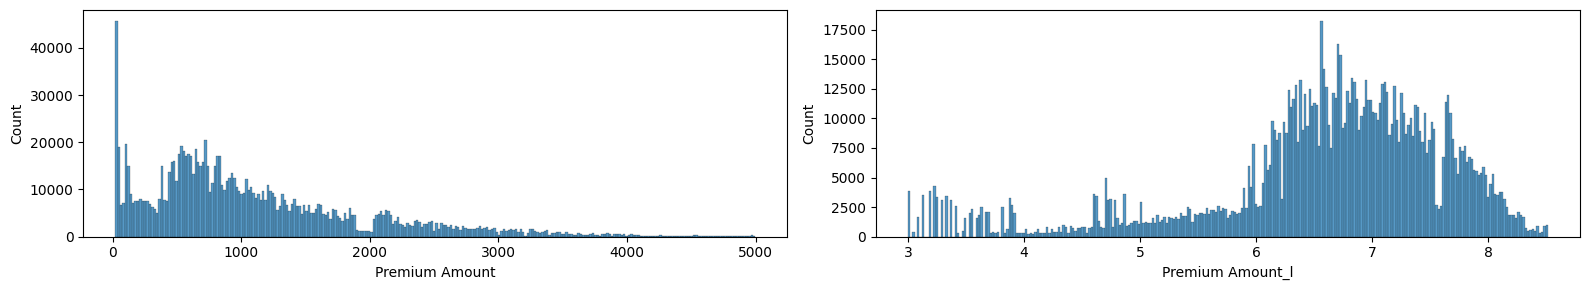

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.histplot(df_train['Premium Amount'], ax=axes[0])
sns.histplot(df_train['Premium Amount_l'], ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
df_train[target].agg(['min', 'max', 'median', 'mean']), df_train[target].mode()[0]

(min       2.995732
 max       8.516994
 median    6.770790
 mean      6.590527
 Name: Premium Amount_l, dtype: float32,
 3.218876)

In [14]:
df_train['Premium Amount'].value_counts().iloc[:10]

Premium Amount
25.0     4268
24.0     3901
20.0     3849
23.0     3524
28.0     3418
26.0     3375
48.0     3307
29.0     3139
100.0    3125
27.0     3074
Name: count, dtype: int64

In [15]:
df_train[target].value_counts().iloc[:10]

Premium Amount_l
3.218876    4268
3.178054    3901
2.995732    3849
3.135494    3524
3.332205    3418
3.258096    3375
3.871201    3307
3.367296    3139
4.605170    3125
3.295837    3074
Name: count, dtype: int64

# Categorical Variables

In [16]:
from scipy.stats import kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

In [17]:
pd.concat([
    df_train[i].value_counts().to_frame().pipe(lambda x: x.set_index(pd.MultiIndex.from_product([[i], x.index.tolist()], names=['Var', 'Cat'])))
    for i in X_nom
], axis = 0)

count
Var            Cat                  
Marital Status Single         395391
               Married        394316
               Divorced       391764
Occupation     Employed       282750
               Self-Employed  282645
               Unemployed     276530
Property Type  House          400349
               Apartment      399978
               Condo          399673

In [18]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = False
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

Year         Month  Occupation  Customer Feedback  Location  \
stat     7.440078e+02  7.051816e+01    6.276566           4.409469  3.429708   
pvalue  1.495212e-158  9.736743e-11    0.043357           0.110280  0.179990   

        Education Level  Policy Type  Property Type  Exercise Frequency  \
stat           3.804265     1.907457       1.738442            2.756426   
pvalue         0.283390     0.385302       0.419278            0.430723   

        Marital Status  Smoking Status   Weekday        Day    Gender  
stat          1.167640        0.169736  3.844106  22.607314  0.017928  
pvalue        0.557764        0.680346  0.697763   0.831053  0.893486

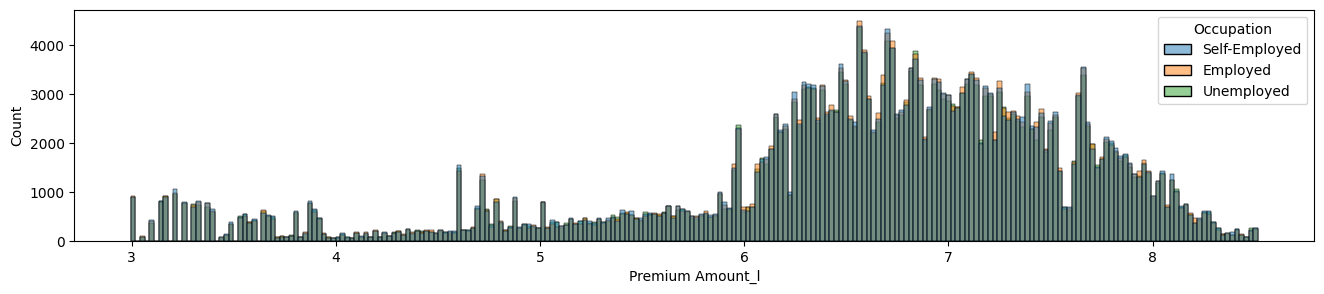

In [19]:
plt.figure(figsize=(16, 3))
sns.histplot(df_train, x=target ,hue='Occupation')
plt.show()

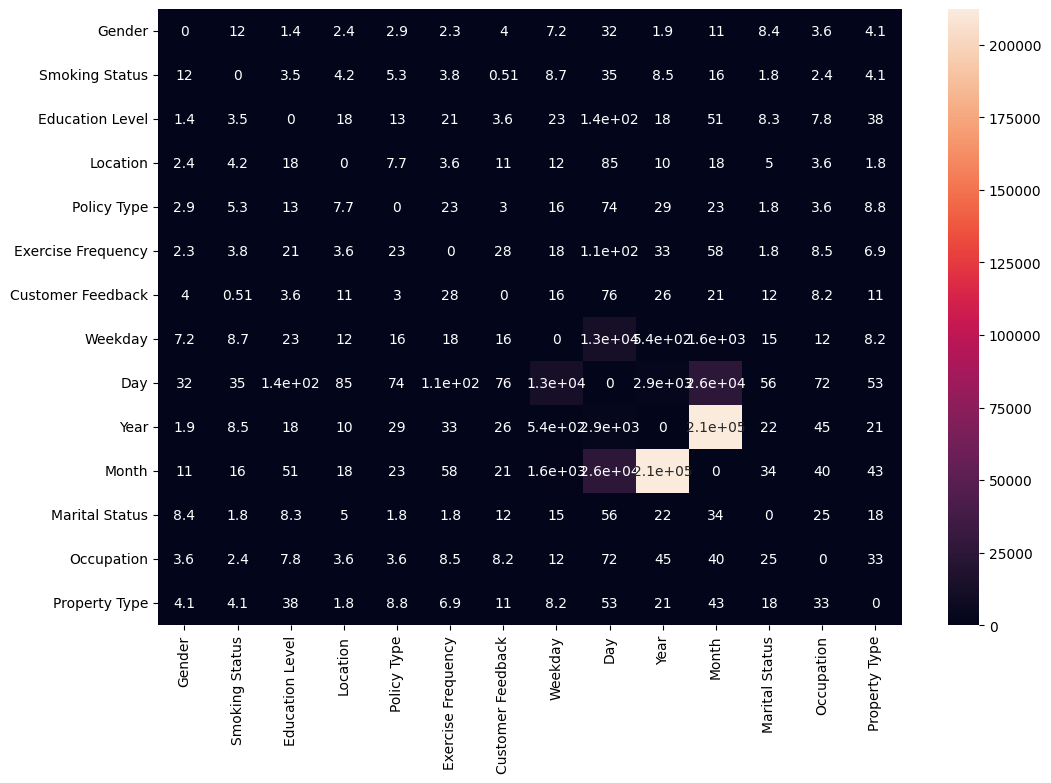

In [20]:
plt.figure(figsize=(12, 8))
df_chi2 = sc.cache_result(
    'chi2_stat',
    lambda : pd.DataFrame(
        squareform(pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns = v))[0])),
        index = X_cat, columns=X_cat
    ), rerun = False
)
sns.heatmap(df_chi2, annot=True)
plt.show()

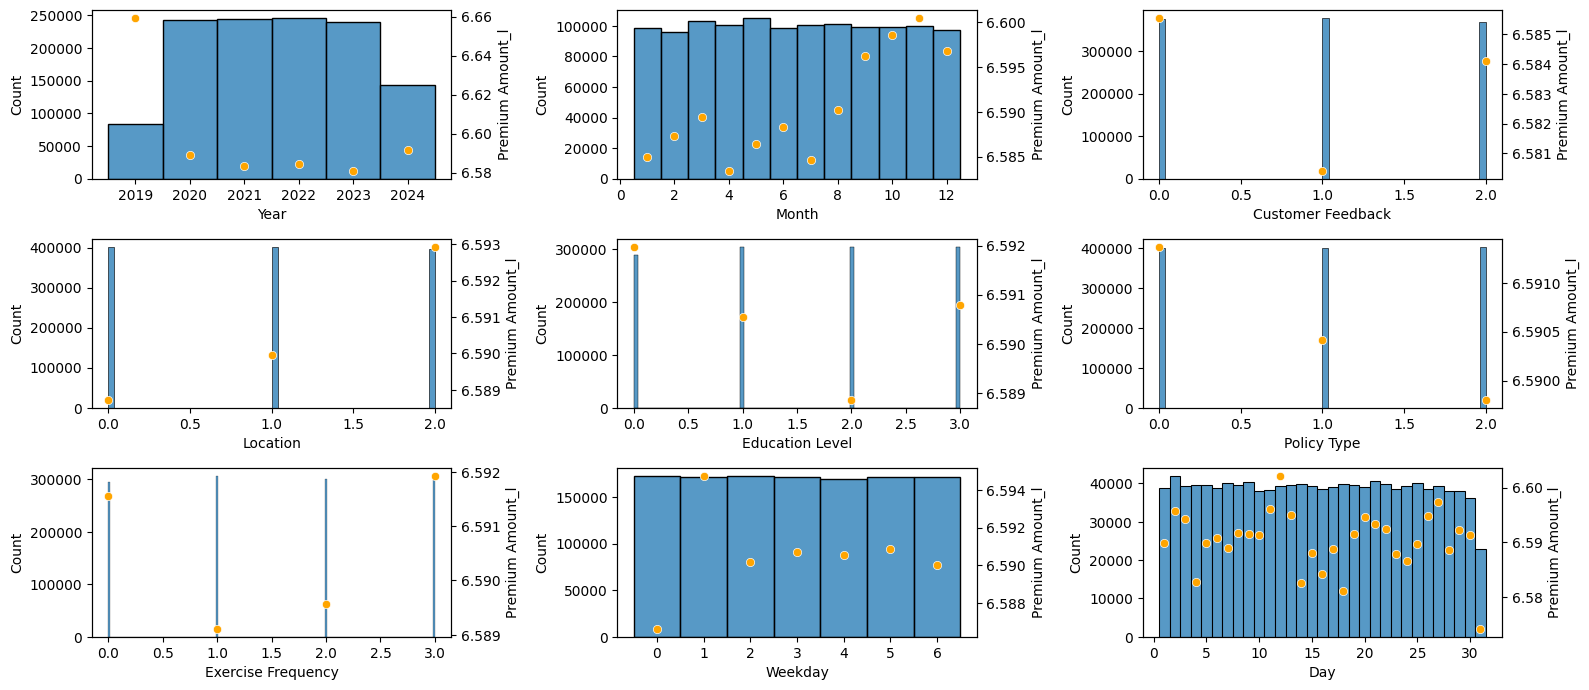

In [21]:
X = [i for i in df_kruskal_tgt.T['pvalue'].sort_values(ascending=True).index if i in X_ord]
sc.cache_fig('hist_and_scatter_ord',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

### Year와 Month의 관계


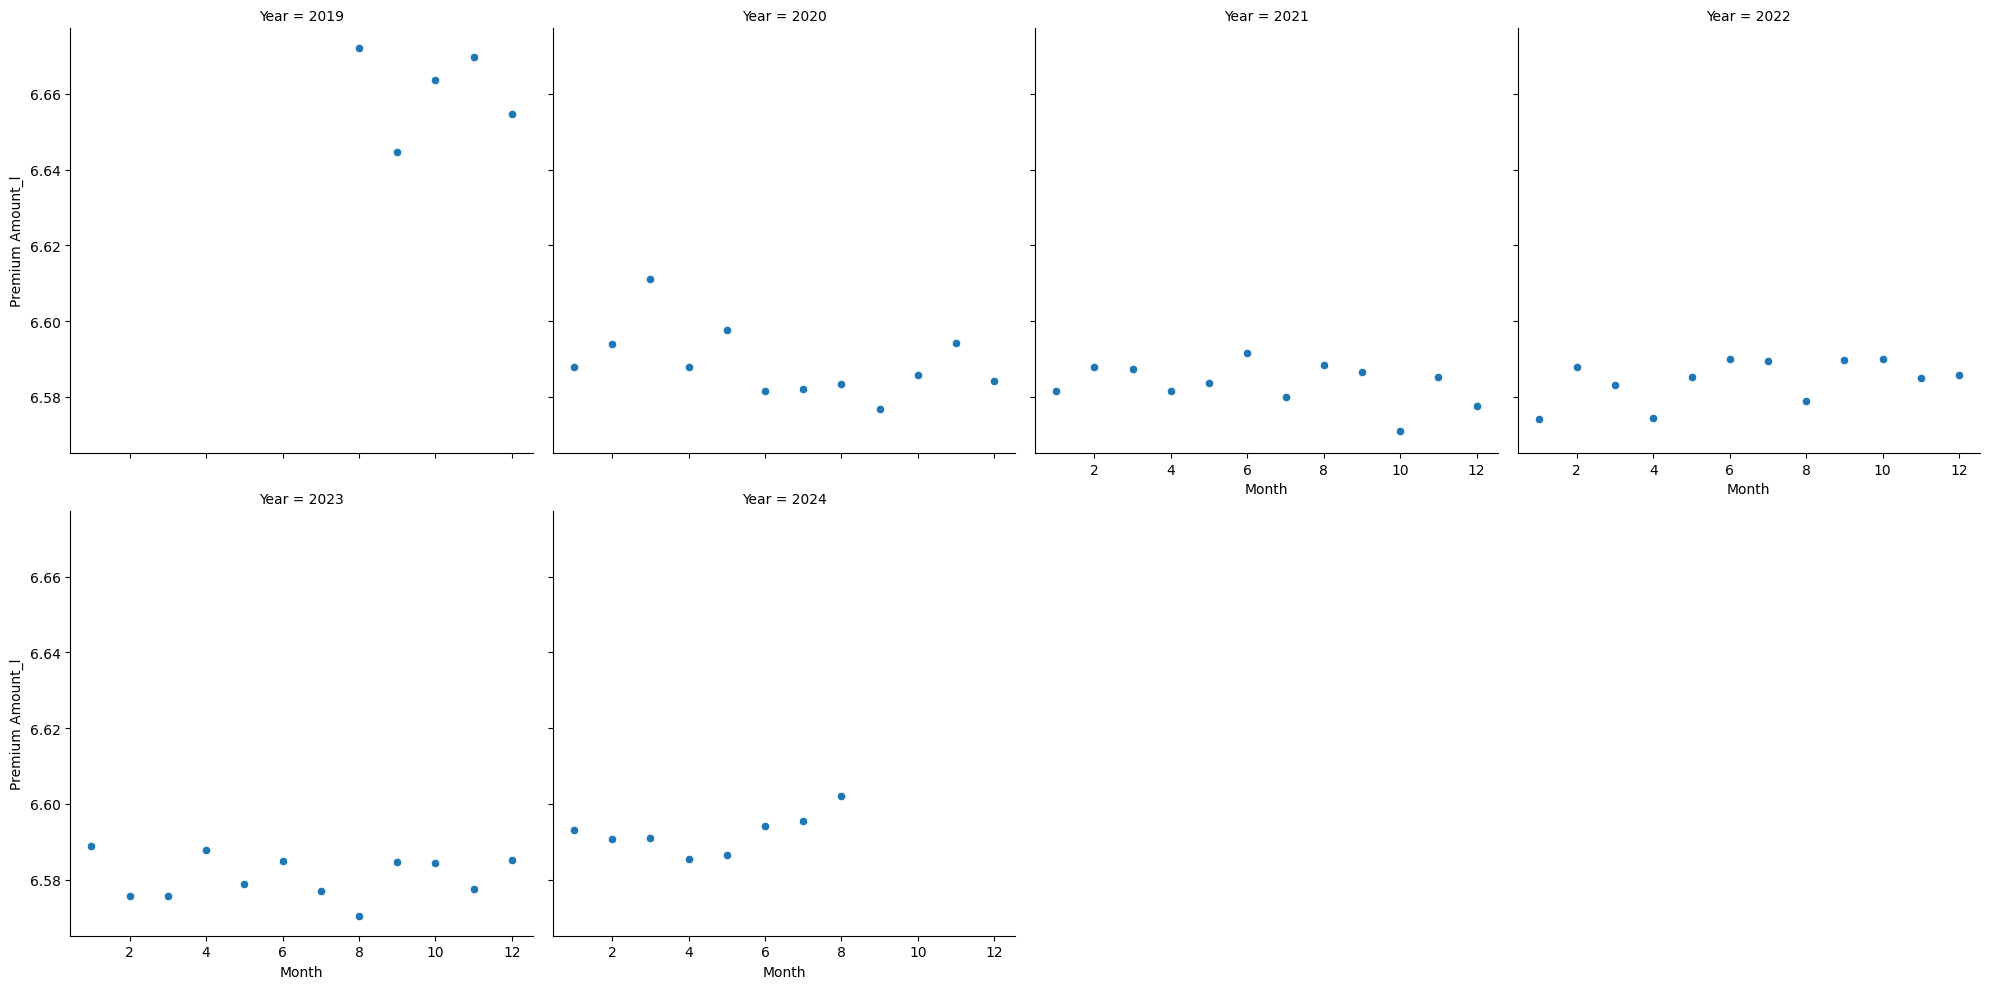

In [22]:
df_train.groupby(['Year', 'Month'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Month', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

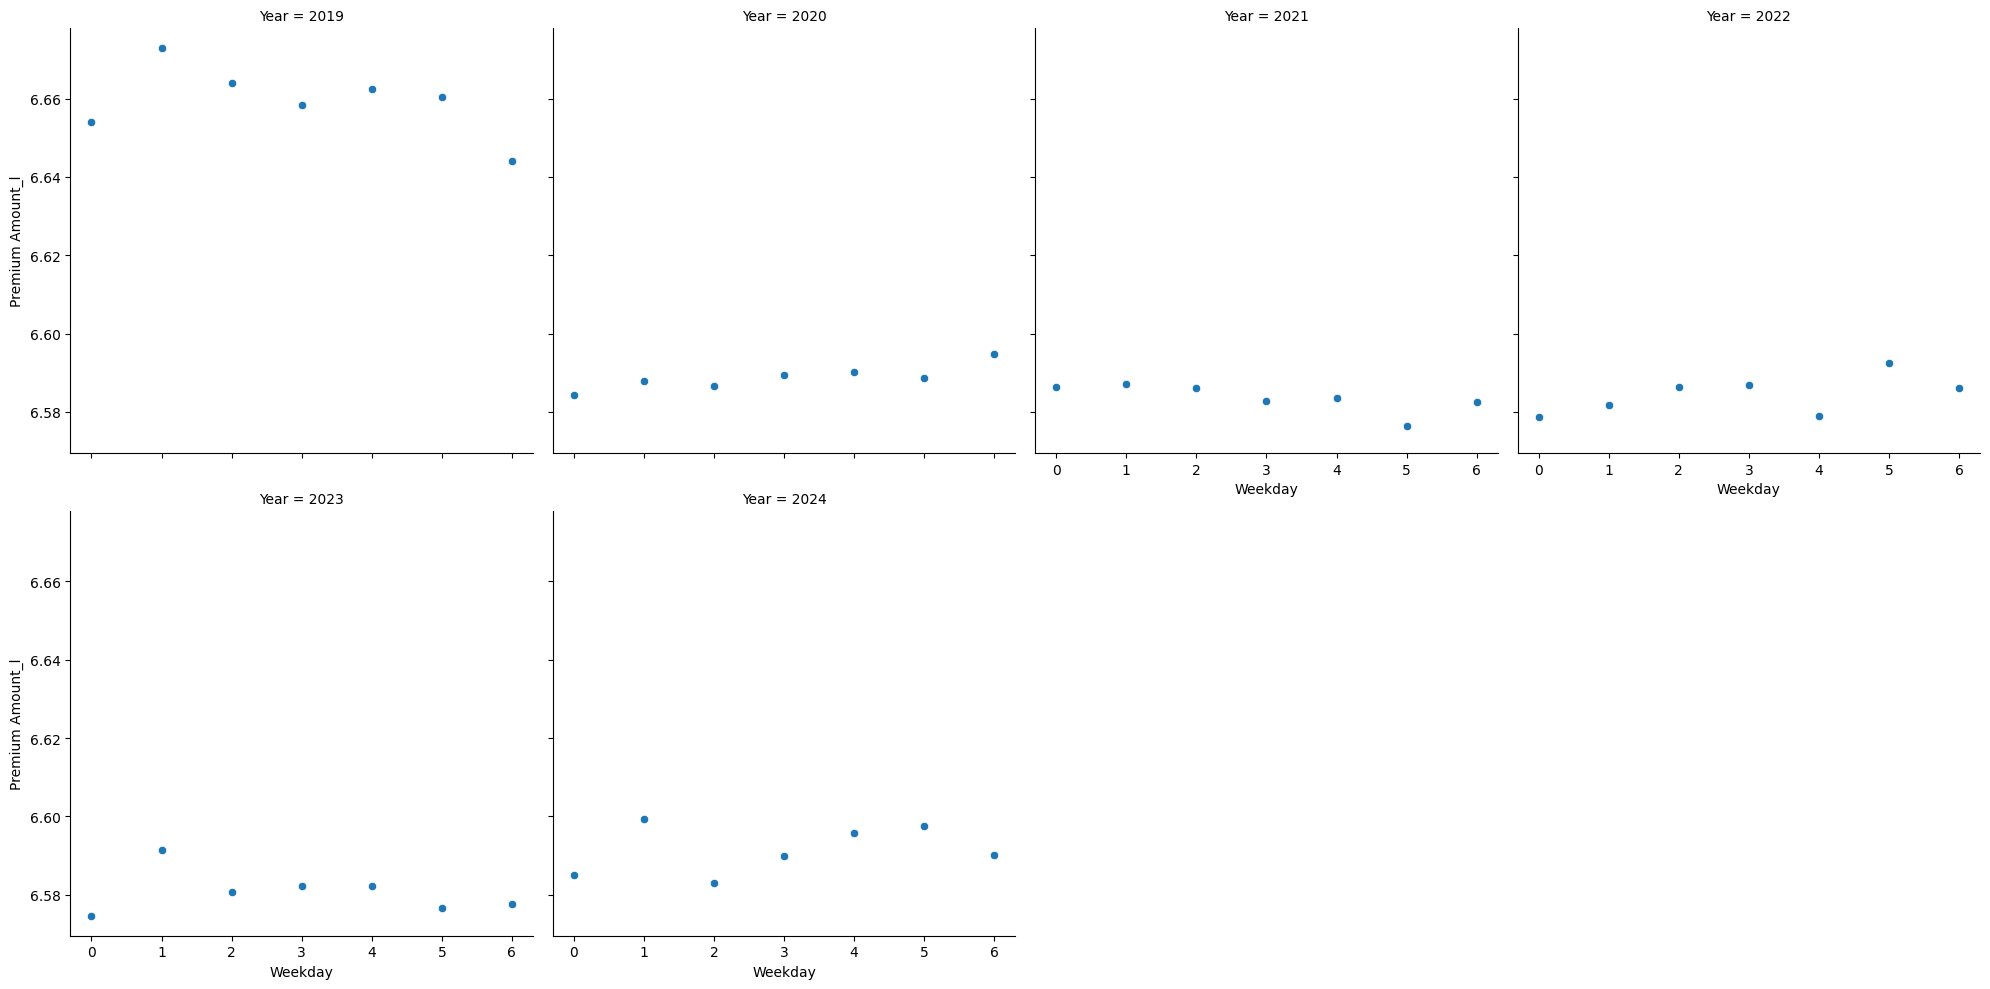

In [23]:
df_train.groupby(['Year', 'Weekday'], observed=True, as_index = False)[target].mean().pipe(
    lambda x: sns.relplot(x, x = 'Weekday', y = target, col = 'Year', kind='scatter', col_wrap = 4)
)
plt.show()

# Numeric Variables

In [24]:
from scipy.stats import kruskal, spearmanr

# Policy Start Date에서 Policy가 적용된 기간을 Policy의 최대값에서 도출합니다.
if 'Policy Days' not in df_train.columns:
    df_train['Policy Days'] = (df_train['Policy Start Date'].max() - df_train['Policy Start Date']).dt.days
    df_test['Policy Days'] = (df_train['Policy Start Date'].max() - df_test['Policy Start Date']).dt.days
    df_org['Policy Days'] = (df_train['Policy Start Date'].max() - df_org['Policy Start Date']).dt.days
    X_num.append('Policy Days') 

## Spearman with target

In [25]:
df_spearman_target = sc.cache_result('spearman_target',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target

Annual Income  Credit Score  Previous Claims  Health Score  \
stat        -0.061437     -0.043928         0.044549  1.601483e-02   
pvalue       0.000000      0.000000         0.000000  9.044248e-65   

         Policy Days       Age  Number of Dependents  Vehicle Age  \
stat    1.018274e-02 -0.002329             -0.001610     0.000870   
pvalue  6.775903e-29  0.011369              0.092669     0.340707   

        Insurance Duration  
stat             -0.000071  
pvalue            0.937799

## Spearman between variables

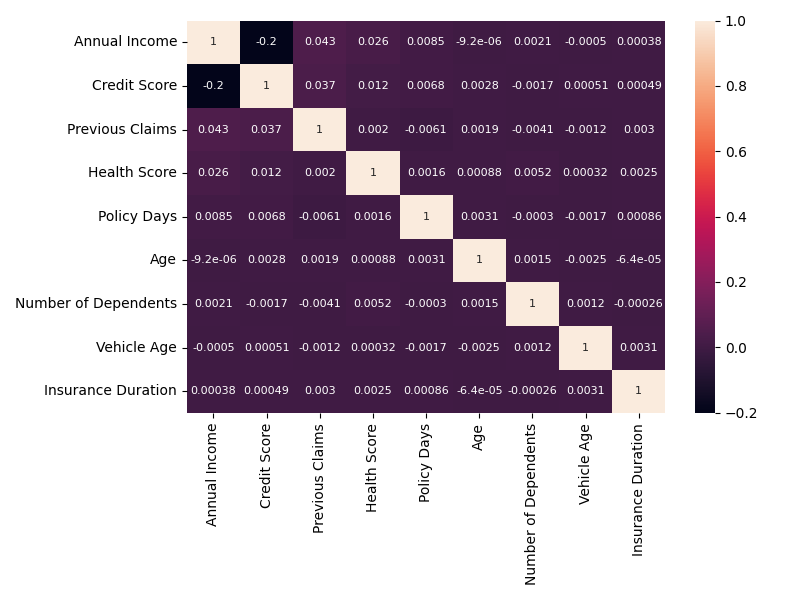

In [26]:
sc.cache_fig('spearman_between variables',
    lambda x: sns.heatmap(
        df_train[
            df_spearman_target.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

## Kruskal with Categorical Variables

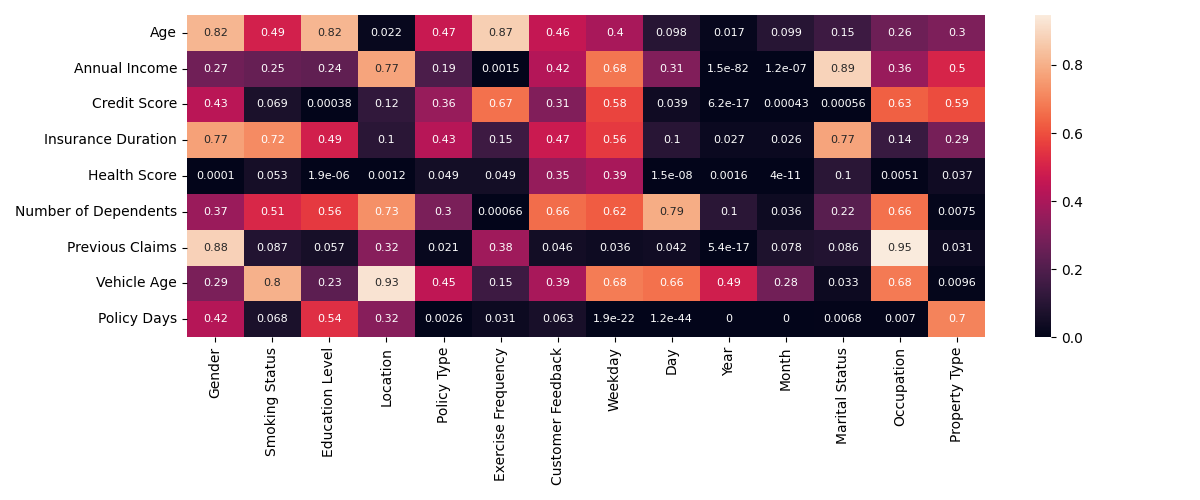

In [27]:
df_kruskal_cat = sc.cache_result('kruskal_cat', 
    lambda : pd.concat([
        df_train.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat',
    lambda x: sns.heatmap(
        df_kruskal_cat, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

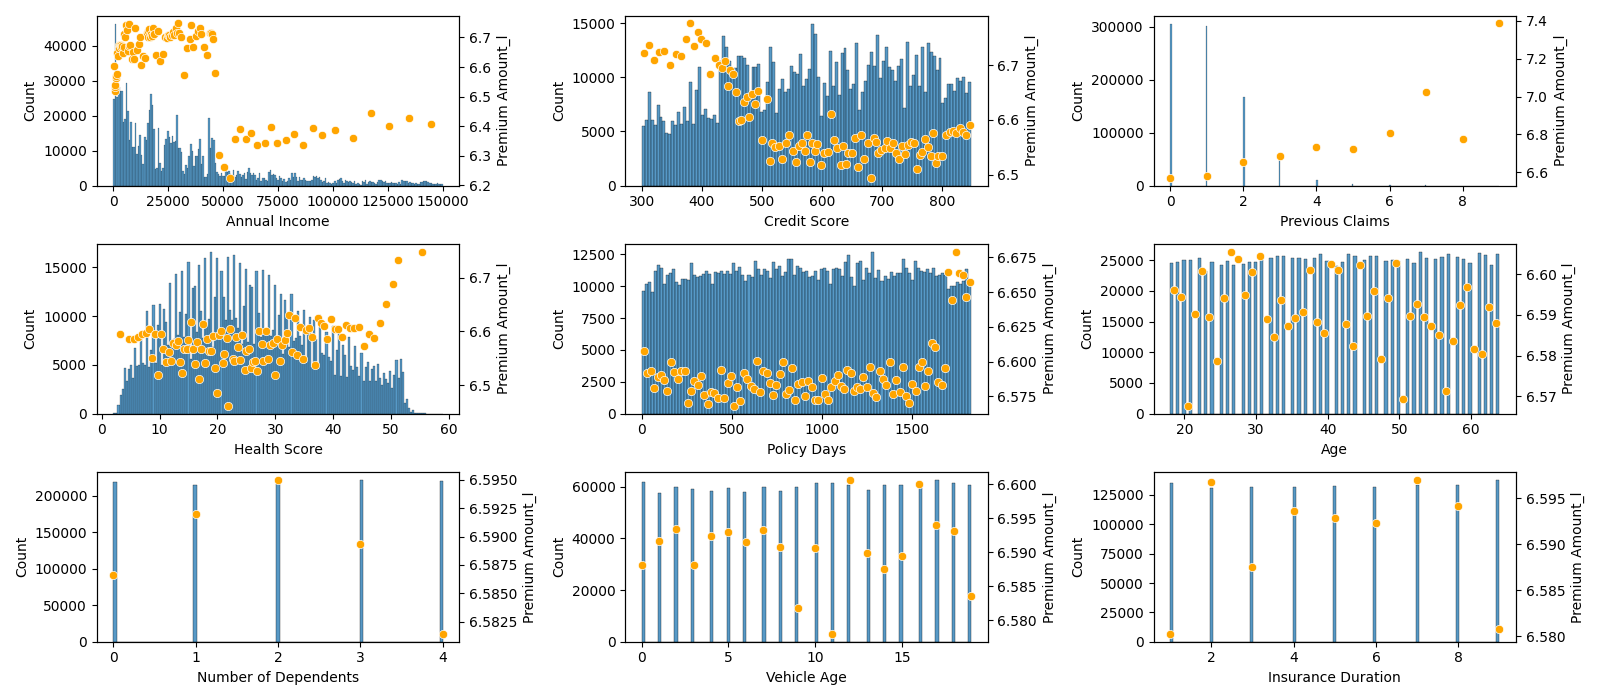

In [28]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 0
)

In [136]:
pd.concat([
    pd.Series(
        kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
    )
    for i in ['Age', 'Vehicle Age', 'Insurance Duration', 'Number of Dependents']
], axis=1)

Age  Vehicle Age  Insurance Duration  Number of Dependents
stat    89.648062    32.696028           34.352082             24.190392
pvalue   0.000124     0.026054            0.000035              0.000073

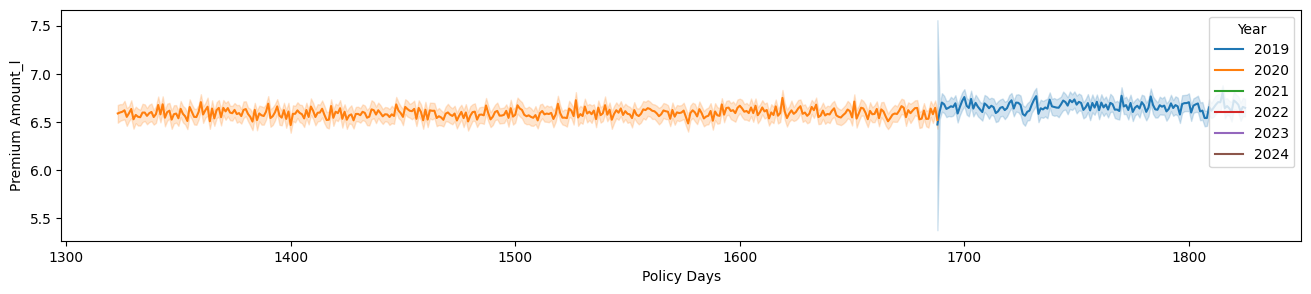

In [29]:
plt.figure(figsize = (16, 3))
sns.lineplot(df_train.query('Year == 2019 or Year == 2020'), x = 'Policy Days', y = target, hue='Year')
plt.show()

target의 분산 많이 커진 시점은 2020년 1월 1일 이후입니다.

In [30]:
# 2020-1-1을 기점으로 target의 변화가 생깁니다.
df_train['Year_2019'] = df_train['Year'] == 2019

In [31]:
df_train.groupby(['Year_2019'])[target].std()

Year_2019
False    1.099746
True     1.127359
Name: Premium Amount_l, dtype: float32

In [32]:
pd.concat([
    df_train['Previous Claims'].fillna(-1).value_counts().rename('cnt'),
    df_train.groupby(df_train['Previous Claims'].fillna(-1))[target].agg(['mean', 'std'])
], axis=1).T

Previous Claims           -1.0            0.0            1.0            2.0  \
cnt              364029.000000  305433.000000  300811.000000  167661.000000   
mean                  6.566922       6.570236       6.581253       6.655844   
std                   1.095505       1.099844       1.097853       1.118836   

Previous Claims           3.0           4.0          5.0         6.0  \
cnt              49011.000000  10668.000000  2018.000000  302.000000   
mean                 6.687772      6.731228     6.724175    6.806338   
std                  1.112466      1.096185     1.104733    1.099726   

Previous Claims        7.0       8.0       9.0  
cnt              58.000000  8.000000  1.000000  
mean              7.022580  6.775523  7.386471  
std               0.850956  1.198675       NaN

In [33]:
df_train['Previous Claims_C'] = df_train['Previous Claims'].fillna(-1).clip(-1, 7)

In [34]:
df_train.groupby('Year_2019')[['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims', target]].mean()

Annual Income  Credit Score  Health Score  Previous Claims  \
Year_2019                                                               
False       32480.503906    592.682922     25.598755         1.002977   
True        36263.808594    596.130676     25.812834         0.998899   

           Premium Amount_l  
Year_2019                    
False              6.585322  
True               6.659417

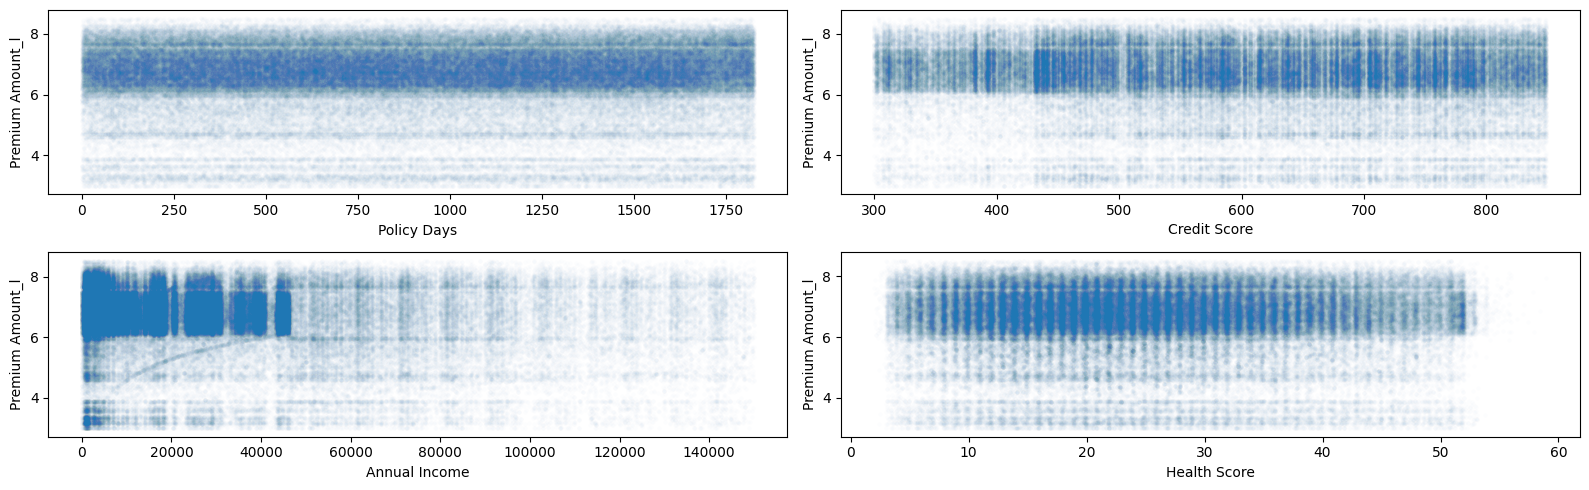

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 5))
for i, ax in zip(['Policy Days', 'Credit Score', 'Annual Income', 'Health Score'], axes.flatten()):
    sns.scatterplot(
        df_train.sample(frac = 0.2), x = i, y = target, alpha = 0.01, s = 10, ax = ax
    )
plt.tight_layout()
plt.show()

In [36]:
display(df_train.groupby(df_train['Annual Income'] >= 46500)[target].std())
df_train['Annual Income_46K'] = df_train['Annual Income'] >= 46500

Annual Income
False    1.023724
True     1.325675
Name: Premium Amount_l, dtype: float32

In [37]:
df_train['Annual Income_b'] = pd.cut(df_train['Annual Income'], bins=[0, 2400, 46500, np.inf], labels=[0, 1, 2])
display(df_train.groupby('Annual Income_b', observed=True)[target].std())

Annual Income_b
0    1.217834
1    0.970338
2    1.325678
Name: Premium Amount_l, dtype: float32

<Axes: xlabel='Annual Income', ylabel='Credit Score'>

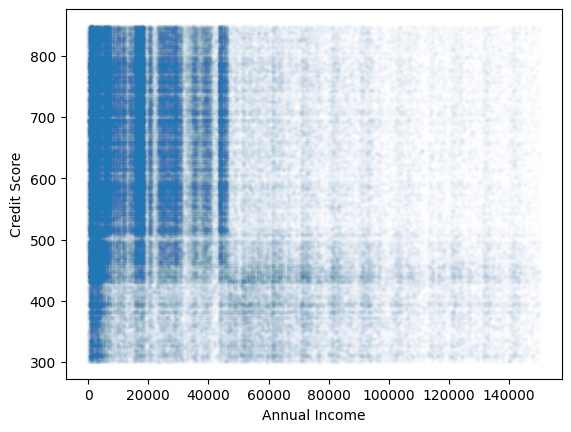

In [38]:
sns.scatterplot(df_train.sample(frac = 0.3), x = 'Annual Income', y = 'Credit Score', s = 10, alpha = 0.01)

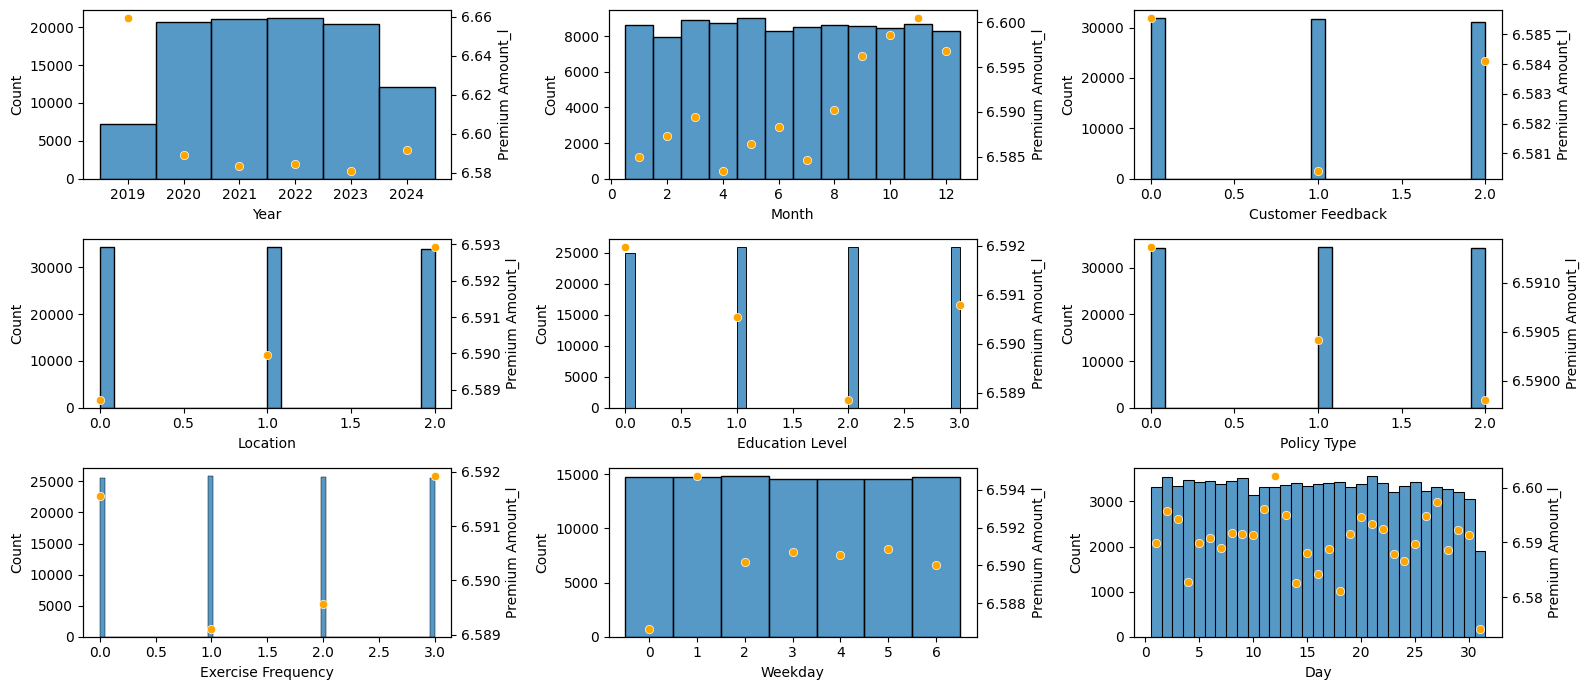

In [39]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter2',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 0'), i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

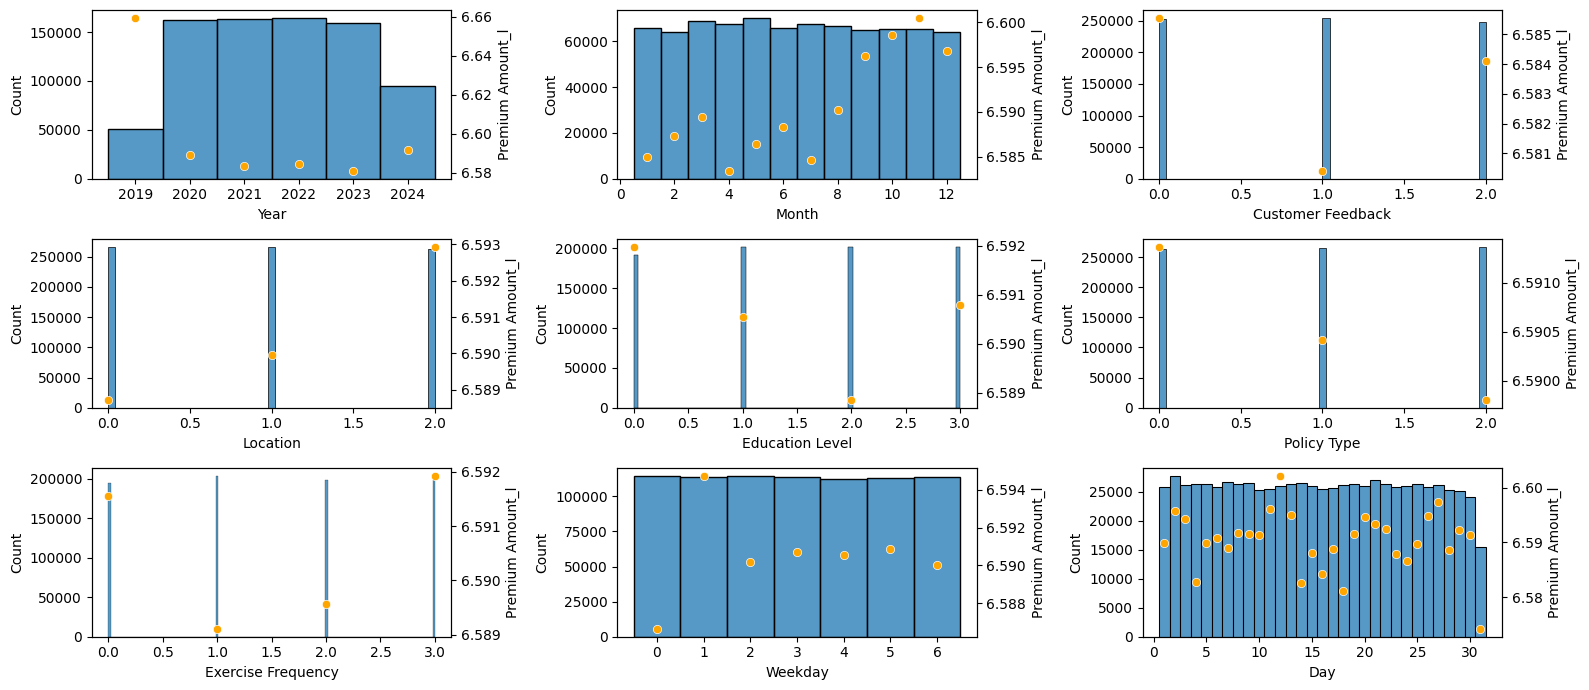

In [40]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter3',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 1'), i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

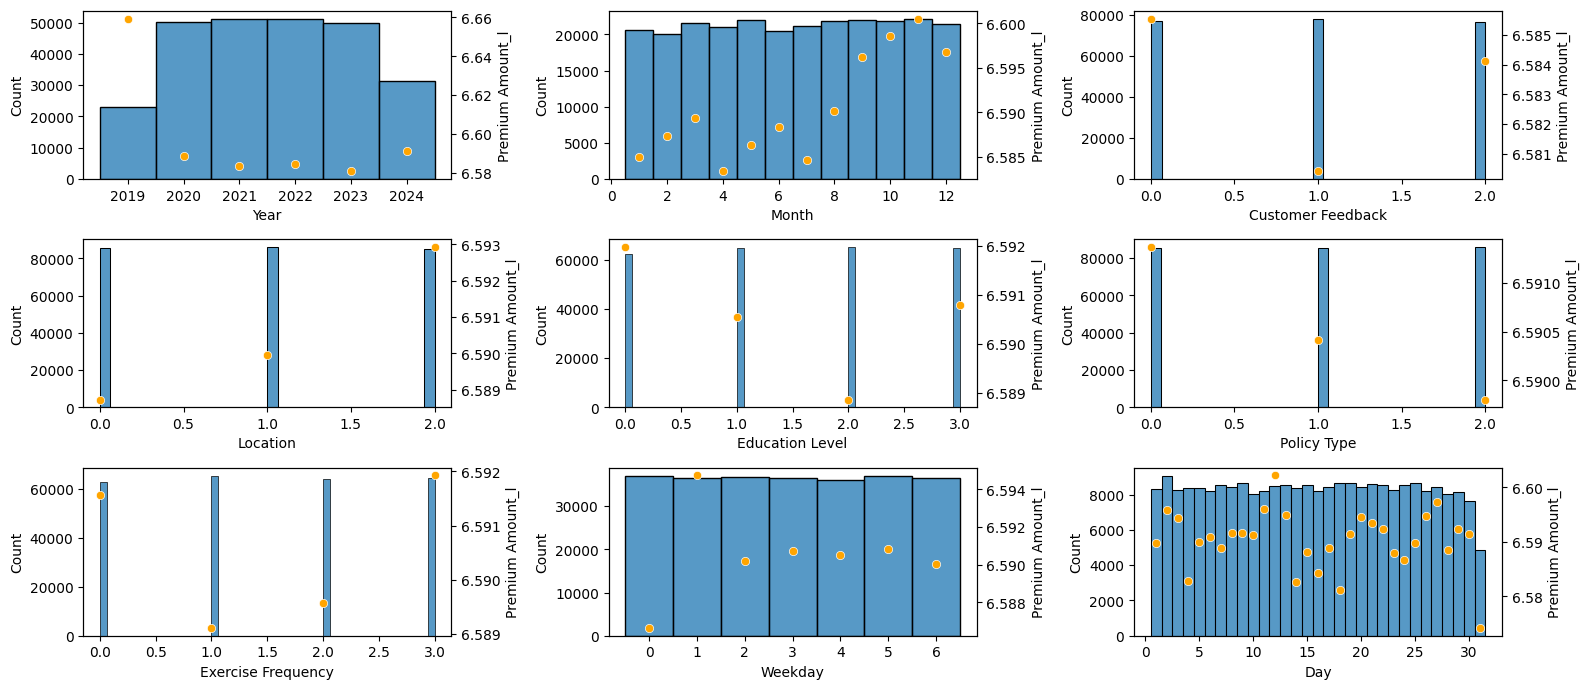

In [41]:
x = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter3',
    lambda axes: [hist_and_scatter(df_train.query('`Annual Income_b` == 2'), i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw = 1
)

In [42]:
from scipy.stats import pearsonr
df_train[['Annual Income', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x['Annual Income']).transform('size'),
        x[target]
    ), (x['Annual Income']).nunique())
)

(PearsonRResult(statistic=0.0704849697287615, pvalue=0.0), 88593)

In [43]:
from scipy.stats import pearsonr
df_train[['Credit Score', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x['Credit Score'] // 50).transform('size'),
        x[target]
    ), (x['Credit Score'] // 50).nunique())
)

(PearsonRResult(statistic=-0.04927246212144346, pvalue=0.0), 11)

In [44]:
df_train[['Health Score', target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby((x['Health Score'] * 7) // 1).transform('size'),
        x[target]
    ), ((x['Health Score'] * 7) // 1).nunique())
)

(PearsonRResult(statistic=-0.030831004687861624, pvalue=7.503749209671335e-235),
 390)

In [145]:
col = 'Insurance Duration'
df_train[[col, target]].dropna().pipe(
    lambda x: (pearsonr(
        x.groupby(x[col]).transform('size'),
        x[target]
    ), (x[col]).nunique())
)

(PearsonRResult(statistic=-0.004007052584004155, pvalue=1.1360153483324342e-05),
 10)

In [46]:
df_train['Annual Income_d'] = df_train['Annual Income'] // 1000
df_train['Credit Score_d'] = df_train['Credit Score'] // 50
df_train['Health Score_d'] = df_train['Health Score'] // 1

In [47]:
df_train[['Annual Income_d', 'Credit Score_d', target]].pipe(
    lambda x: (pearsonr(
        x.groupby(['Annual Income_d', 'Credit Score_d']).transform('size').fillna(0),
        x[target]
    ), len(x[['Annual Income_d', 'Credit Score_d']].value_counts()))
)

(PearsonRResult(statistic=0.06909769472136891, pvalue=0.0), 1650)

In [48]:
df_train[['Annual Income_d', 'Health Score_d', target]].pipe(
    lambda x: (pearsonr(
        x.groupby(['Annual Income_d', 'Health Score_d']).transform('size').fillna(0),
        x[target]
    ), len(x[['Annual Income_d', 'Health Score_d']].value_counts()))
)

(PearsonRResult(statistic=0.0625314459454274, pvalue=0.0), 7913)

In [49]:
s_vcnt_A = (df_train['Annual Income'] // 1).value_counts()
s_vcnt_C = (df_train['Credit Score'] // 50).value_counts()
s_vcnt_H = ((df_train['Health Score'] * 7) // 1).value_counts()
s_vcnt_AC = df_train[['Annual Income_d', 'Credit Score_d']].value_counts()
s_vcnt_AH = df_train[['Annual Income_d', 'Health Score_d']].value_counts()

df_train['Annual Income_Freq'] = (df_train['Annual Income'] // 1).map(s_vcnt_A)
df_train['Credit Score_Freq'] = (df_train['Credit Score'] // 50).map(s_vcnt_C)
df_train['AC_Freq'] = df_train[['Annual Income_d', 'Credit Score_d']].apply(tuple, axis=1).map(s_vcnt_AC)
df_train['AH_Freq'] = df_train[['Annual Income_d', 'Health Score_d']].apply(tuple, axis=1).map(s_vcnt_AH)
df_train['Health Score_Freq'] = ((df_train['Health Score'] * 7) // 1).map(s_vcnt_H)

df_train['Annual Income_Freqz'] = df_train['Annual Income_Freq'].fillna(0)
df_train['Credit Score_Freqz'] = df_train['Credit Score_Freq'].fillna(0)
df_train['AC_Freqz'] = df_train['AC_Freq'].fillna(0)
df_train['AH_Freqz'] = df_train['AH_Freq'].fillna(0)
df_train['Health Score_Freqz'] = df_train['Health Score_Freq'].fillna(0)

In [50]:
df_train[['Annual Income_Freq', 'Credit Score_Freq', 'AC_Freq', target]].corr()

Annual Income_Freq  Credit Score_Freq   AC_Freq  \
Annual Income_Freq            1.000000           0.144360  0.313713   
Credit Score_Freq             0.144360           1.000000  0.360444   
AC_Freq                       0.313713           0.360444  1.000000   
Premium Amount_l              0.070485          -0.049272  0.059790   

                    Premium Amount_l  
Annual Income_Freq          0.070485  
Credit Score_Freq          -0.049272  
AC_Freq                     0.059790  
Premium Amount_l            1.000000

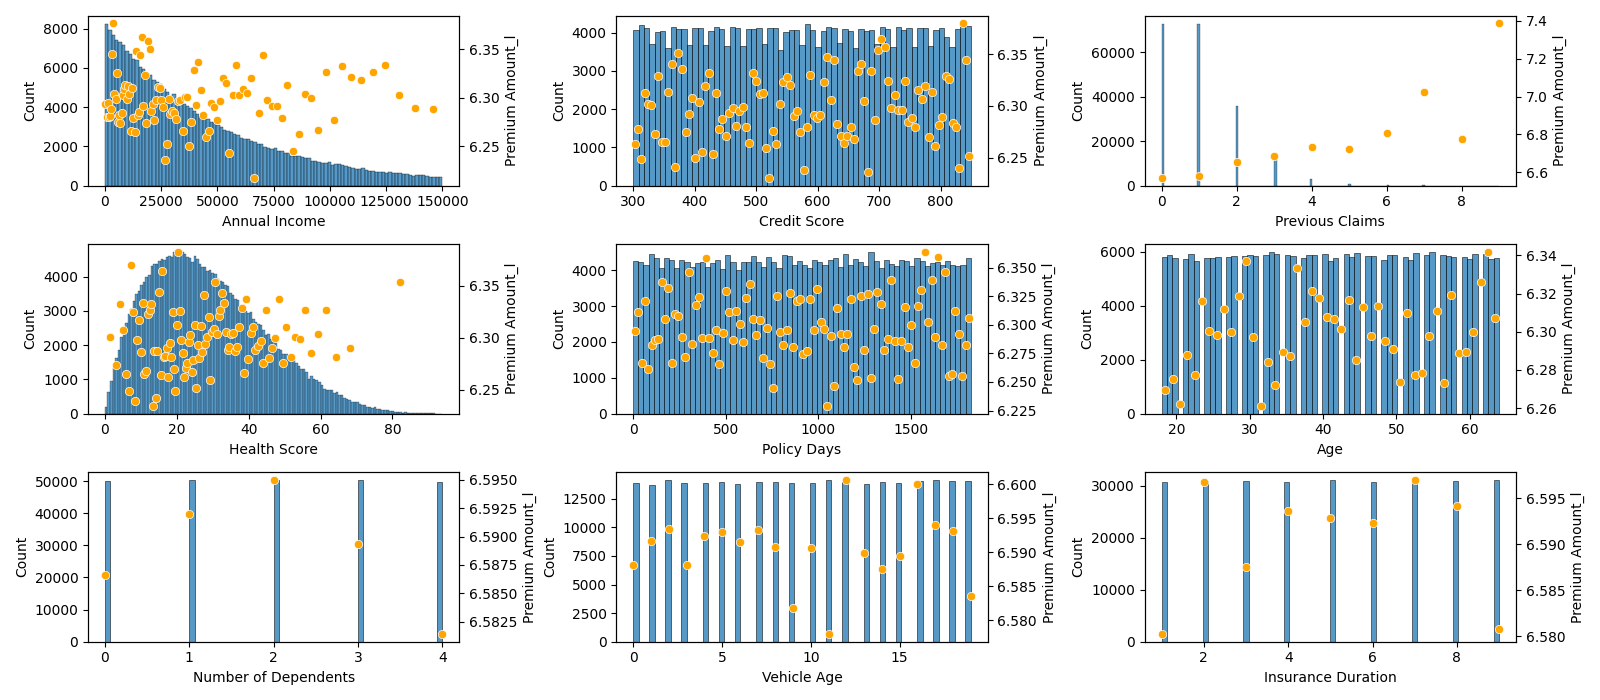

In [51]:
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter_org',
    lambda axes: [hist_and_scatter(df_org, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw=0
)

# Missing Variables

In [52]:
pd.concat([
    df_train[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(train)').sort_values(ascending=False).to_frame().T,
    df_test[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(test)').sort_values(ascending=False).to_frame().T,
    df_org[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(org)').sort_values(ascending=False).to_frame().T
], axis=0).fillna(0)

Previous Claims  Occupation  Credit Score  \
na_rate(train)         0.303358    0.298396      0.114902   
na_rate(test)          0.303503    0.298906      0.114314   
na_rate(org)           0.291501    0.291501      0.100000   

                Number of Dependents  Customer Feedback  Health Score  \
na_rate(train)              0.091393           0.064853      0.061730   
na_rate(test)               0.091412           0.065345      0.061811   
na_rate(org)                0.100000           0.065800      0.038001   

                Annual Income       Age  Marital Status  Vehicle Age  \
na_rate(train)       0.037457  0.015588        0.015441     0.000005   
na_rate(test)        0.037325  0.015611        0.015420     0.000004   
na_rate(org)         0.050043  0.016801        0.017998     0.000000   

                Insurance Duration  
na_rate(train)        8.333333e-07  
na_rate(test)         2.500000e-06  
na_rate(org)          0.000000e+00

In [53]:
if 'Previous Claims_isna' not in df_train.columns:
    X_isna = ['Previous Claims', 'Occupation', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age', 'Marital Status']
    df_train = df_train.join(df_train[X_isna].isna().rename(columns = lambda x: x + '_isna'))
    df_org = df_org.join(df_org[X_isna].rename(columns = lambda x: x + '_isna'))
    X_isna = [i + '_isna' for i in X_isna]

## Missing Value Processing

In [61]:
# 수치형 변수의 결측치를 0으로 채웁니다.
if 'Credit Score_fz' not in df_train.columns:
    X_fn = ['Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age']
    df_fz = df_train[X_fn].fillna(0).astype('int').rename(columns = lambda x: x + '_fz')
    X_fz = df_fz.columns.tolist()
    df_train = df_train.join(df_fz)

In [55]:
# 명목형 변수의 결측치를 Unknown으로 채웁니다.
if 'Occupation_funk' not in df_train.columns:
    df_train['Occupation_funk'] = df_train['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Marital Status_funk'] = df_train['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Customer Feedback_fm1'] = df_train['Customer Feedback'].fillna(-1).astype('int8')
    df_train['Previous Claims_fm1'] = df_train['Previous Claims'].fillna(-1).astype('int8')

# Train/Test/Org Difference

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_roc_auc_diff(df_0, df_1, X_input):
    df_diff = pd.concat([
        df_0[X_input].assign(is_1 = False),
        df_1[X_input].assign(is_1 = True)
    ], axis = 0)
    df_train_diff, df_test_diff = train_test_split(df_diff, train_size = 0.8, stratify = df_diff['is_1'])
    clf_diff = lgb.LGBMClassifier(random_state=123, verbose = 0)
    clf_diff.fit(df_diff[X_input], df_diff['is_1'], categorical_feature = X_cat)
    return (
        roc_auc_score(df_test_diff['is_1'], clf_diff.predict_proba(df_test_diff[X_input])[:, 1]),
        pd.Series(clf_diff.feature_importances_, index=X_input)
    )
(roc1, s_imp1), (roc2, s_imp2) = sc.cache_result('diff_result',
    lambda : (
        get_roc_auc_diff(df_train, df_test, X_cat + X_num),
        get_roc_auc_diff(df_train, df_org, X_cat + X_num + ['Premium Amount'] + X_isna)
    ), rerun=0
)
roc1, roc2

(0.549038528359375, 0.8153901992337851)

In [57]:
s_imp2.sort_values(ascending=False).iloc[:15].to_frame().T

Annual Income  Health Score  Premium Amount  Credit Score  Previous Claims  \
0            932           682             609           320              127   

   Customer Feedback  Marital Status_isna  Day  Policy Days  Year  \
0                121                   74   48           37    18   

   Number of Dependents  Month  Education Level  Age  Insurance Duration  
0                    12     11                4    2                   1

Train은 Test와 구분이 어려운 것으로 보아 차이가 크지 않음을 알 수 있고,

Org와는 차이가 보입니다. Org 데이터를 포함하여 학습시키는 것은 성능의 개선을 주지 않을 가능성이 큽니다. 

In [58]:
from sklearn.metrics import mean_squared_error
def check_improve():
    df_org[target] = np.log(df_org['Premium Amount'] + 1e-7)
    df_train_2, df_valid = train_test_split(df_train, train_size = 0.8)
    return (
        mean_squared_error(
            df_valid[target],
            lgb.LGBMRegressor(random_state = 123, verbose=0).fit(df_train_2[X_cat + X_num], df_train_2[target]).predict(df_valid[X_cat + X_num])
        ),
        mean_squared_error(
            df_valid[target],
            pd.concat([df_train_2[X_cat + X_num + [target]], df_org[X_cat + X_num + [target]]])\
            .pipe(lambda x: lgb.LGBMRegressor(random_state = 123, verbose=0).fit(x[X_cat + X_num], x[target]).predict(df_valid[X_cat + X_num]))
        )
    )
sc.cache_result('check_improve', check_improve)

(1.1171271174753696, 1.137173196197595)

# Analyze with ML

In [59]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: mean_squared_error(df[target].sort_index(), prds.sort_index()) ** 0.5,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

In [65]:
def gb_shap_learning_result(train_result, df, interaction = True):
    explainer = shap.TreeExplainer(train_result['model'])
    processor = train_result['preprocessor']
    result = {
        'X': pd.DataFrame(processor.transform(df), index=df.index, columns=train_result['variables'])
    }
    result['shap_values'] = explainer.shap_values(result['X'])
    if interaction:
        result['shap_interaction_values'] = explainer.shap_interaction_values(result['X'])
    return result

def cb_interaction_importance(train_result):
    s_name = pd.Series(train_result['variables'])
    return pd.DataFrame(
        train_result['model'].get_feature_importance(type = 'Interaction'),
        columns = ['Var1', 'Var2', 'Importance']
    ).assign(
        Var1 = lambda x: x['Var1'].map(s_name),
        Var2 = lambda x: x['Var2'].map(s_name),
    )

In [62]:
hparams = {
    'X_mm': ['Previous Claims_fm1', 'Credit Score_fz', 'Health Score_fz', 'Annual Income_fz', 'Age_fz', 'Annual Income_Freqz','Credit Score_Freqz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_fz'],
    'X_ohe': ['Customer Feedback_fm1'], 'ohe': {'drop': 'first'}
}
sgml.cv(df_train, ss, hparams, config, lr_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

{'valid_scores': [1.0883007331387047],
 'valid_prd': id
 319351     6.667707
 604239     6.527907
 200654     6.581460
 452912     6.677830
 721610     6.393835
              ...   
 270080     6.736501
 640185     6.845366
 1035776    6.591895
 1053882    6.786961
 714747     6.133757
 Length: 120000, dtype: float64,
 'model_result': [],
 'train_scores': [1.087904629622114]}

In [66]:
X_num2 = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 
         'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100, 'max_depth': 7},
    'X_num': X_num2, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0537718415467985], [1.0511812638068703])

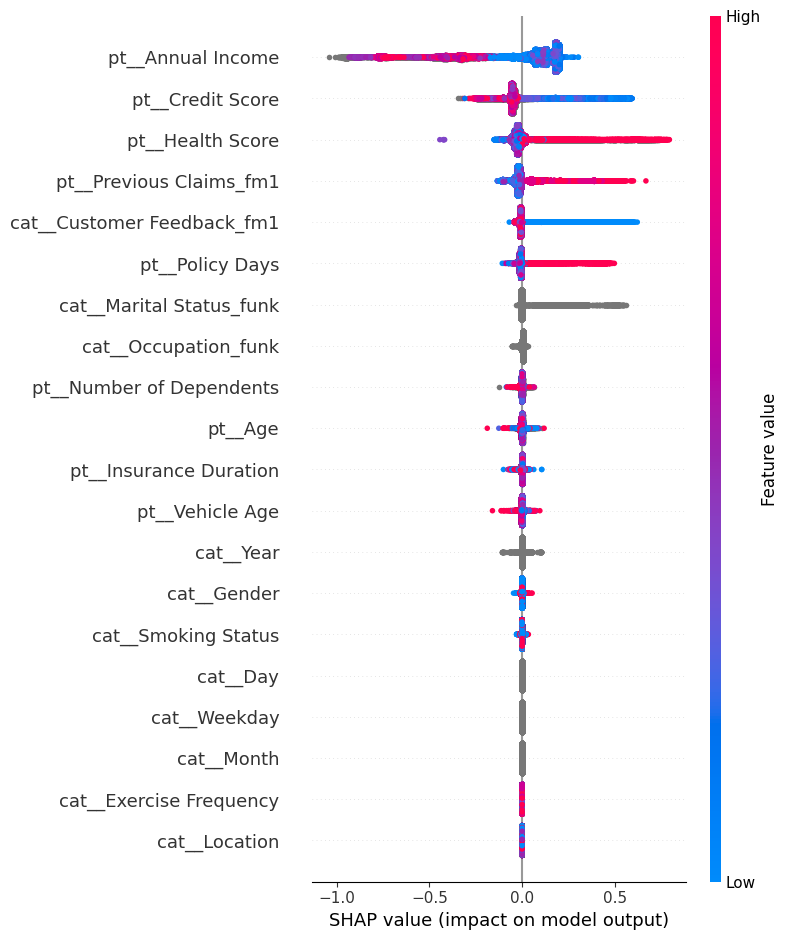

In [67]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

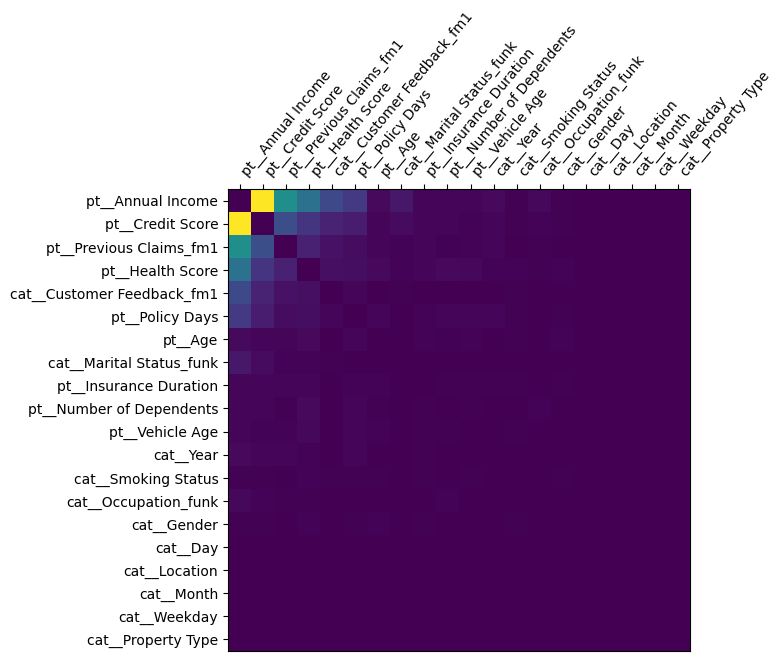

In [68]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

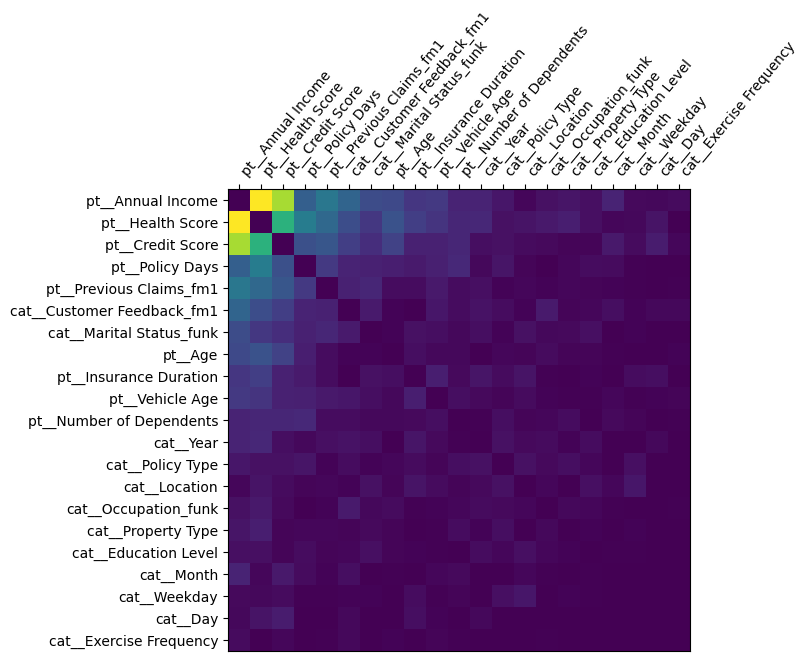

In [70]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

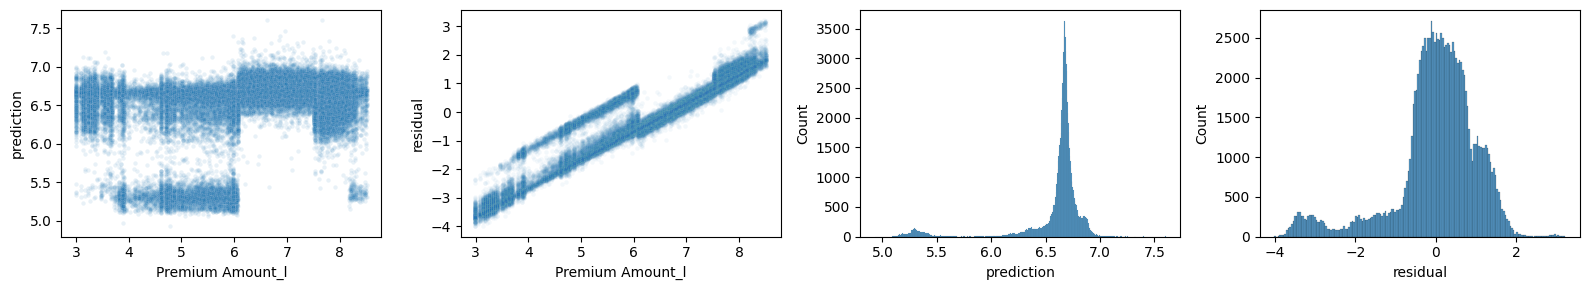

In [71]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

target이 4와 6 사이 그리고 8 이상인 구간에서ㅓ 예측값의 분포는 6.5 와 5.4 중심으로 나뉜다는 것을 알 수 있습니다. 이 현상을 살펴 봅니다.

In [72]:
df_valid[X_ord + ['Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Year  Marital Status_funk      Month  Location  \
stat    2.778052e+02         8.110781e+01  32.259411  4.467585   
pvalue  5.894889e-58         1.775796e-17   0.000693  0.107121   

        Education Level   Weekday    Gender        Day  Property Type  \
stat           3.574804  5.745527  0.414696  27.688559       0.489813   
pvalue         0.311189  0.452292  0.519596   0.586937       0.782778   

        Policy Type  Exercise Frequency  Customer Feedback  Occupation_funk  \
stat       0.461780            0.710675           0.160676         0.165752   
pvalue     0.793827            0.870690           0.922805         0.982919   

        Smoking Status  
stat               0.0  
pvalue             1.0

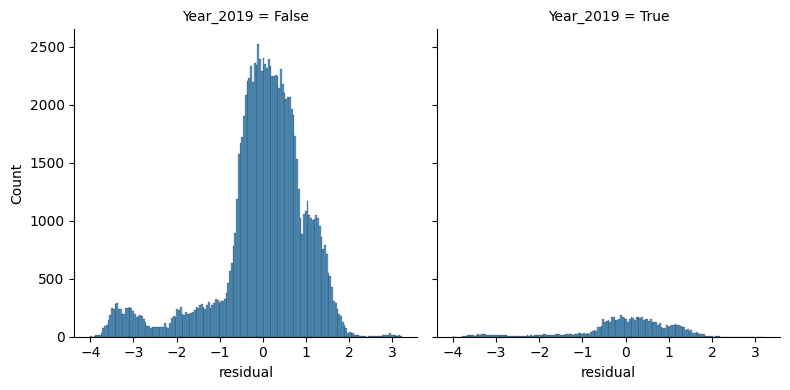

In [73]:
sns.displot(
    x=residual, col = df_valid['Year_2019'], height=4
)

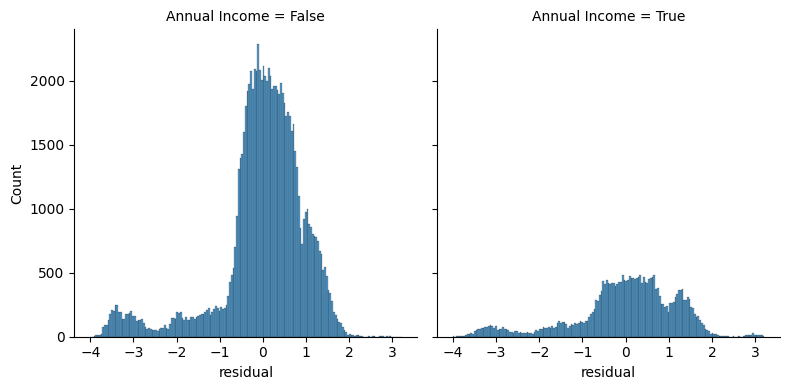

In [74]:
sns.displot(
    x=residual, col = df_valid['Annual Income'] >= 45000, height=4
)

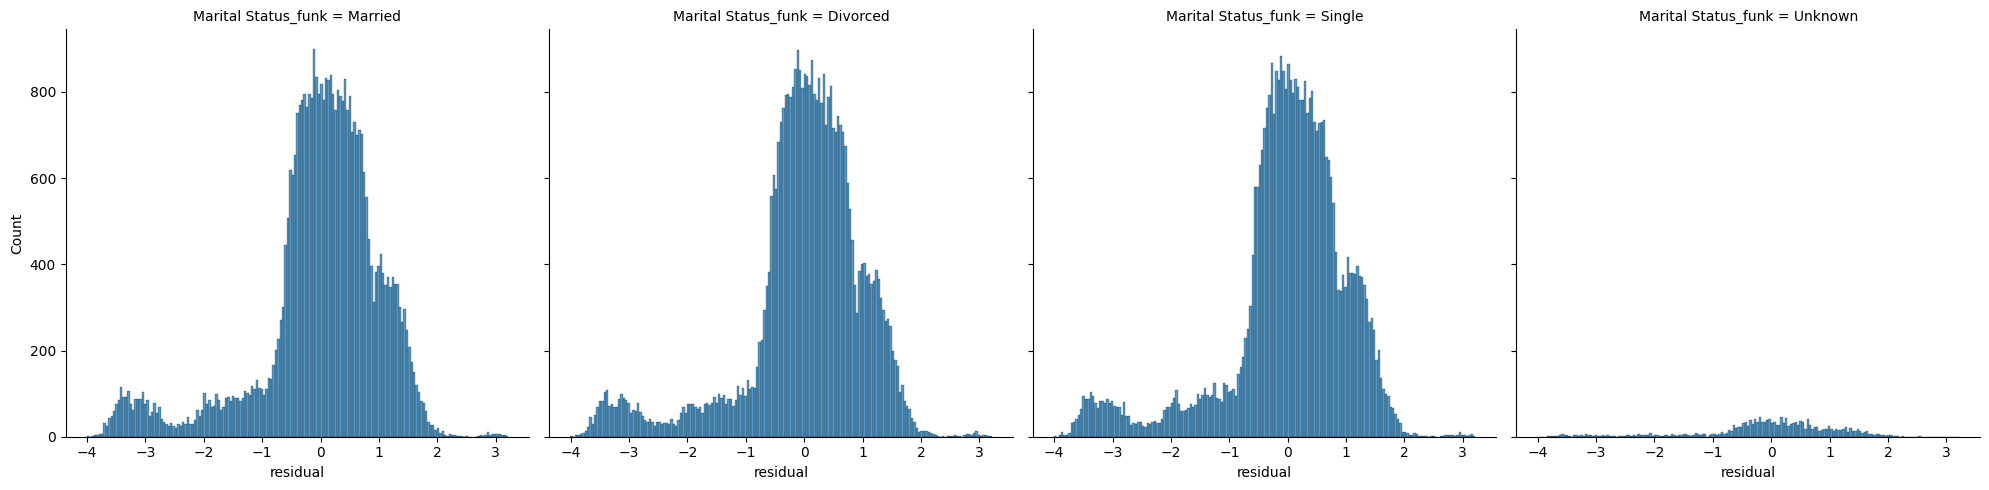

In [75]:
sns.displot(
    x=residual, col = df_valid['Marital Status_funk']
)

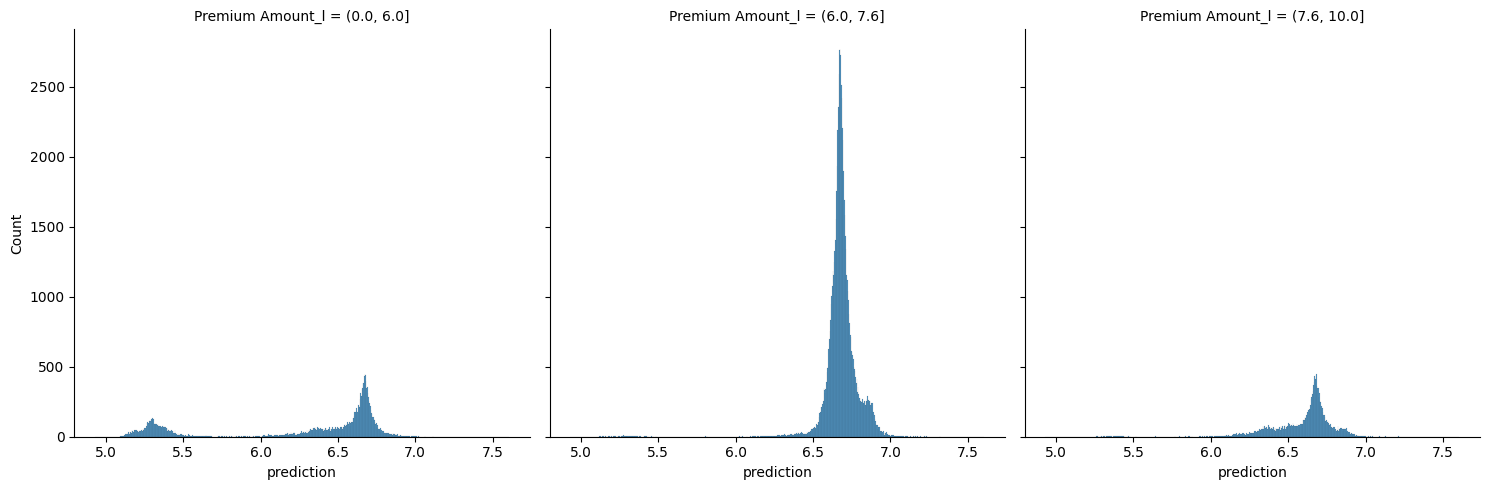

In [76]:
sns.displot(
    x=y_prd, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

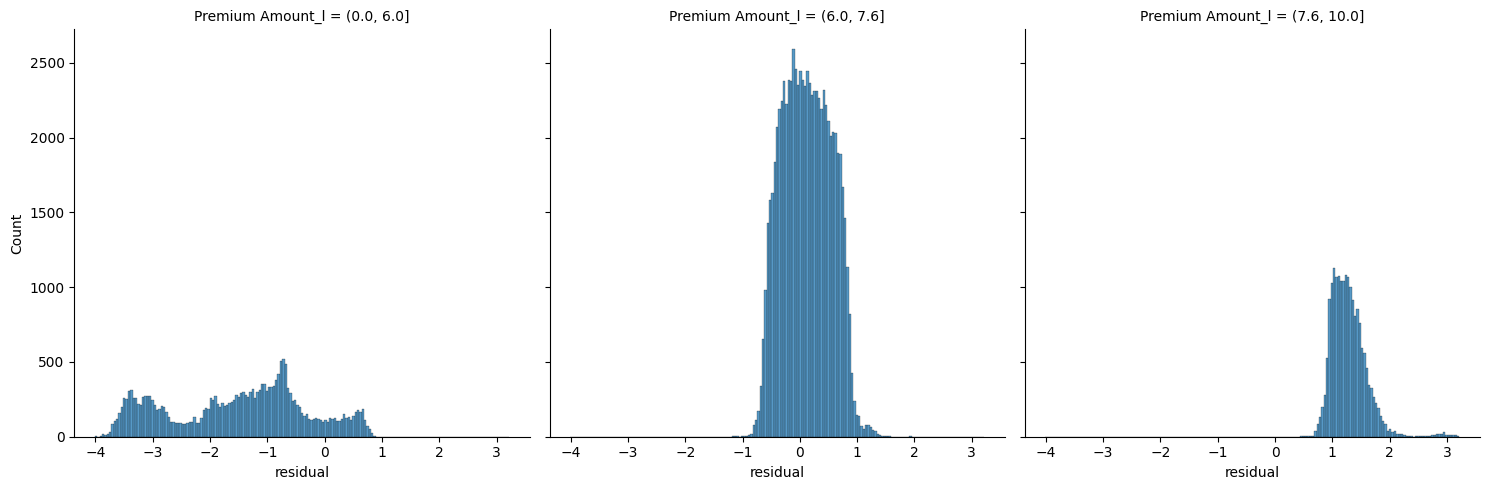

In [77]:
sns.displot(
    x=residual, col = pd.cut(df_valid[target], [0, 6, 7.6, 10])
)

target의 구간에 따라 잔차의 분포가 차이가 납니다. 잔차의 구간을 예측하는 모델을 만들어 봅니다. 

In [78]:
df_valid[X_num].isna().apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Annual Income  Health Score  Previous Claims  Credit Score       Age  \
stat      6298.204175  3.210982e+02     1.604573e+02  8.154674e+01  0.655668   
pvalue       0.000000  8.350288e-72     8.989511e-37  1.711653e-19  0.418094   

        Number of Dependents  Insurance Duration  Vehicle Age  Policy Days  
stat                0.119236                 0.0          0.0          0.0  
pvalue              0.729864                 1.0          1.0          1.0

In [79]:
from scipy.stats import mannwhitneyu
df_valid[X_num].apply(
    lambda x: mannwhitneyu(x.loc[y_prd < 6.0].dropna(), x.loc[y_prd >= 6.0].dropna())
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

Annual Income  Credit Score  Previous Claims   Policy Days  \
stat      487619359.0   351568705.0     1.126949e+08  3.357557e+08   
pvalue            0.0           0.0    1.043264e-207  1.507694e-14   

        Health Score   Vehicle Age  Number of Dependents           Age  \
stat    3.219131e+08  3.509954e+08          2.986644e+08  3.484206e+08   
pvalue  6.924193e-04  4.806512e-02          7.841992e-02  3.038884e-01   

        Insurance Duration  
stat          3.576046e+08  
pvalue        6.161986e-01

In [80]:
pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000119
Annual Income           0.004229
Previous Claims         0.005649
Age                     0.182747
Number of Dependents    0.446831
Customer Feedback       0.598805
Credit Score            0.689701
Occupation              0.884093
Marital Status          0.986827
dtype: float64

Health Score의 결측 여부와 Annual Income의 결측 여부는 잔차와 관련성이 높습니다.

# Using Classification

In [81]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

df_train['target_3'] =  pd.cut(df_train[target], [-np.inf, 6, 7.6, np.inf], labels = [0, 1, 2])
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config_2 = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index),
    'score_func': lambda df, prds: accuracy_score(df['target_3'].sort_index(), prds.idxmax(axis=1).sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': 'target_3',
}

cb_adapter_c = sgml.CBAdapter(cb.CatBoostClassifier)

In [124]:
df_train['Annual Income_qm'] = pd.cut(df_train['Annual Income'], bins = 25)
df_train['Credit Score_qm'] = pd.cut(df_train['Credit Score'],  bins = 10)
df_train['Health Score_qm'] = pd.cut(df_train['Health Score'], bins = 5)

ctype = pd.CategoricalDtype(['NA'] + df_train['Credit Score_qm'].cat.categories.tolist())
df_train['Credit Score_qm'] = dproc.replace_cat(df_train['Credit Score_qm'].astype(ctype).fillna('NA'), lambda x: str(x))
ctype = pd.CategoricalDtype(['NA'] + df_train['Annual Income_qm'].cat.categories.tolist())
df_train['Annual Income_qm'] = dproc.replace_cat(df_train['Annual Income_qm'].astype(ctype).fillna('NA'), lambda x: str(x))
ctype = pd.CategoricalDtype(['NA'] + df_train['Health Score_qm'].cat.categories.tolist())
df_train['Health Score_qm'] = dproc.replace_cat(df_train['Health Score_qm'].astype(ctype).fillna('NA'), lambda x: str(x))

df_train['CA'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Credit Score_qm']], '_')
df_train['AH'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Health Score_qm']], '_')
df_train['CH'] = dproc.combine_cat(df_train[['Credit Score_qm', 'Health Score_qm']], '_')
df_train['ACH'] = dproc.combine_cat(df_train[['Annual Income_qm', 'Credit Score_qm', 'Health Score_qm']], '_')

from sklearn.preprocessing import TargetEncoder
val = ['ACH', 'AH', 'CA', 'CH', 'Credit Score_qm', 'Annual Income_qm', 'Health Score_qm']
kf_dic = {i: list() for i in val}
tgt = TargetEncoder()
for train_idx, test_idx in kf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    for i in val:
        tgt.fit(df_cv_train[[i]], df_cv_train[target])
        #print(i, mean_squared_error(df_valid[target], tgt.transform(df_valid[[i]]))  ** 0.5)
        kf_dic[i].append(
            pd.Series(tgt.transform(df_valid[[i]])[:, 0], index = df_valid.index, name = i)
        )

df_tmp = pd.concat([pd.concat(v, axis=0) for k, v in kf_dic.items()], axis=1)
df_train['CA_C'] = df_tmp['CA'] - df_tmp['Credit Score_qm']
df_train['CA_A'] = df_tmp['CA'] - df_tmp['Annual Income_qm']
df_train['AH_A'] = df_tmp['AH'] - df_tmp['Annual Income_qm']
df_train['AH_H'] = df_tmp['AH'] - df_tmp['Health Score_qm']
df_train['CH_H'] = df_tmp['CH'] - df_tmp['Health Score_qm']
df_train['CH_C'] = df_tmp['CH'] - df_tmp['Credit Score_qm']

df_train['ACH_AH'] = df_tmp['ACH'] - df_tmp['AH']
df_train['ACH_CA'] = df_tmp['ACH'] - df_tmp['CA']
df_train['ACH_CH'] = df_tmp['ACH'] - df_tmp['CH']
df_train['ACH'] = df_tmp['ACH']
df_train['CH'] = df_tmp['CH']
df_train['AH'] = df_tmp['AH']
df_train['CA'] = df_tmp['CA']

In [ ]:
for train_idx, test_idx in kf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    for i in val:
        tgt.fit(df_cv_train[[i]], df_cv_train[target].clip(4.2, 7.5))
        #print(i, mean_squared_error(df_valid[target], tgt.transform(df_valid[[i]]))  ** 0.5)
        kf_dic[i].append(
            pd.Series(tgt.transform(df_valid[[i]])[:, 0], index = df_valid.index, name = i)
        )

In [ ]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year']
hparams = {
    'model_params': {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.05},
    'X_num': X_num + ['Annual Income_Freqz','Credit Score_Freqz', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f', 
                       'CA_C', 'CA_A', 'AH_H', 'AH_A', 'CH_H', 'CH_C'], 
    'X_cat': X_ord3 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb_c', 
    lambda : sgml.cv(
        df_train, ss, hparams, config_2, cb_adapter_c, 
        result_proc = [sgml.cb_learning_result,  cb_interaction_importance]
    ), rerun=1
)
result['valid_scores'], result['train_scores']

In [581]:
result['model_result'][0]['feature_importance'].sort_values(ascending=False).iloc[:15]

pt__CA_C                      15.895839
pt__Previous Claims           12.786132
pt__Annual Income_f           10.347630
pt__Annual Income              7.723607
cat__Customer Feedback_fm1     6.560705
pt__Credit Score_f             5.826420
pt__Annual Income_Freqz        5.535819
pt__Health Score_50            4.823321
pt__CA_A                       4.465320
pt__CH_H                       3.939333
pt__Health Score               2.768864
pt__Policy Days                2.763436
pt__AH_H                       2.126752
pt__CH_C                       2.063841
pt__AH_A                       1.999770
dtype: float64

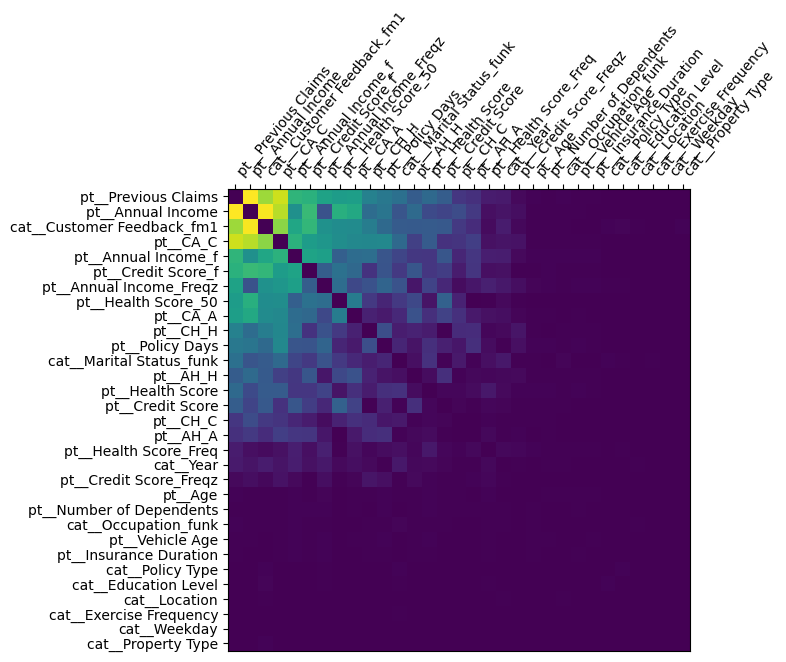

In [580]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

In [127]:
hparams = {
    'X_mm': ['Previous Claims_fm1', 'Credit Score_fz', 'Health Score_fz', 'Annual Income_fz', 'Age_fz'],
    'X_num': ['Year_2019', 'Annual Income_isna', 'Credit Score_isna', 'Health Score_fz', 'Annual Income_Freqz','Credit Score_Freqz', 
              'CA', 'AH', 'CH', 'ACH'],
    'X_ohe': ['Customer Feedback_fm1'], 'ohe': {'drop': 'first'},
}
sgml.cv(df_train, ss, hparams, config, lr_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

{'valid_scores': [1.0704004465165644],
 'valid_prd': id
 319351     6.756150
 604239     6.587069
 200654     6.574711
 452912     6.627570
 721610     5.853343
              ...   
 270080     6.895397
 640185     6.691301
 1035776    6.578886
 1053882    6.787868
 714747     6.061296
 Length: 120000, dtype: float64,
 'model_result': [],
 'train_scores': [1.0702883981949602]}

In [147]:
X_ord3 = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Weekday', 'Year', 'Insurance Duration', 'Number of Dependents_fz']
X_num3 = ['Age', 'Annual Income', 'Credit Score', 'Health Score', 'Previous Claims_fm1', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 200, 'max_depth': 6},
    'X_num': X_num3 + ['Annual Income_Freqz','Credit Score_Freqz', 'Health Score_Freq', 'Health Score_50', 'Annual Income_f', 'Credit Score_f', 
                       'CA_C', 'CA_A', 'AH_H', 'AH_A', 'CH_H', 'CH_C'], 
    'X_cat': X_ord3 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

([1.0513392775565367], [1.0486052989244423])

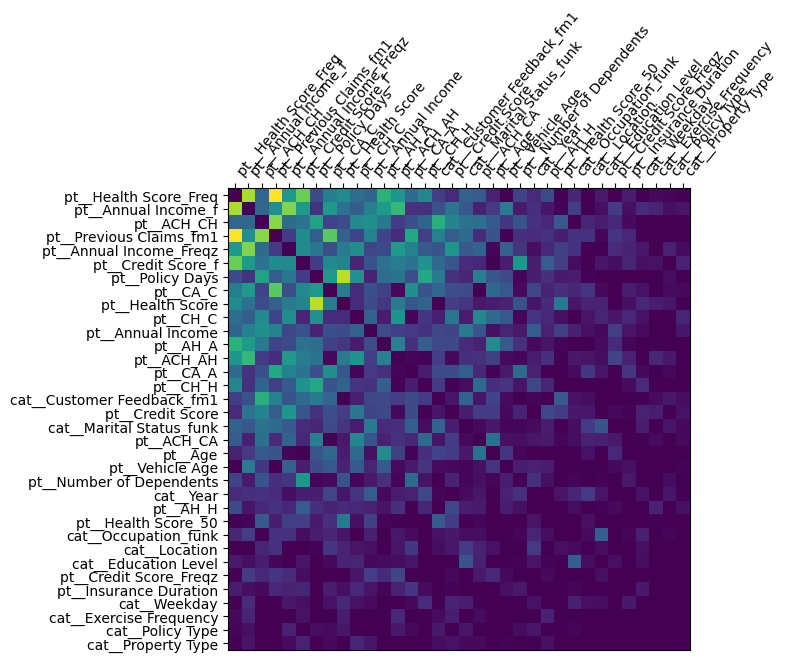

In [132]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.show()

# Missing Variable Imputation with ML

### Health Score

In [85]:
df_kruskal_cat.loc['Health Score'].sort_values().to_frame().T

Month           Day  Education Level    Gender  Location  \
Health Score  3.984273e-11  1.474154e-08         0.000002  0.000102  0.001243   

                  Year  Occupation  Property Type  Policy Type  \
Health Score  0.001639    0.005065       0.037185     0.048545   

              Exercise Frequency  Smoking Status  Marital Status  \
Health Score             0.04929        0.053193        0.104752   

              Customer Feedback   Weekday  
Health Score           0.353783  0.393192

In [86]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Health Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Number of Dependents  \
Health Score        0.02553      0.012016              0.005152   

              Insurance Duration  Previous Claims  Policy Days       Age  \
Health Score            0.002487         0.001989      0.00157  0.000881   

              Vehicle Age  
Health Score     0.000316

In [87]:
from sklearn.model_selection import cross_validate

X_H_cat = ['Year', 'Month', 'Education Level', 'Gender', 'Location', 'Occupation']
clf_lgb = lgb.LGBMClassifier(
    n_estimators = 300, learning_rate = 0.03,
    verbose = 0
)
sc.cache_result(
    'lgb_health_score',
    lambda :
        df_train.loc[df_train['Health Score'].notna()].pipe(
            lambda x: cross_validate(
                clf_lgb, x[X_H_cat + ['Annual Income', 'Credit Score']], x['Health Score'] > 50, scoring = 'roc_auc', cv = 5, 
                params = {'categorical_feature': X_H_cat}, return_train_score = True
            )
        )
    ,rerun = False
)

{'fit_time': array([2.11492085, 2.11409307, 2.04635572, 2.18212724, 2.13023663]),
 'score_time': array([0.40457892, 0.42074275, 0.3715508 , 0.40450954, 0.40835333]),
 'test_score': array([0.68102156, 0.6797946 , 0.68462842, 0.68380156, 0.68300535]),
 'train_score': array([0.7373893 , 0.73636351, 0.72863371, 0.73260448, 0.73749458])}

In [88]:
clf_lgb = sc.cache_result(
    'lgb_health', 
    lambda :df_train.loc[df_train['Health Score'].notna()].pipe(
        lambda x: clf_lgb.fit(x[X_H_cat + ['Annual Income', 'Credit Score']], x['Health Score'] >= 50)
    ), rerun = False
)
df_train['Health Score_50'] = np.where(df_train['Health Score'] >= 50, 1.0, 0.0)
df_train.loc[df_train['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_train.loc[df_train['Health Score'].isna(), X_H_cat + ['Annual Income', 'Credit Score']]
)[:, 1]

In [89]:
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num + ['Health Score_50'], 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

([1.0515041852491787], [1.048139721405053])

In [90]:
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Annual Income           0.004297
Previous Claims         0.004926
Health Score            0.025173
Age                     0.211703
Customer Feedback       0.245683
Number of Dependents    0.498187
Marital Status          0.577071
Credit Score            0.785404
Occupation              0.897954
dtype: float64

Regression 모델로 Health Score의 예측 정확도는 기대할 수 없지만, 시각화 그래프상에서 50 이상은 뚜렷하게 분포가 차이가 남을 알 수 있고, 

이를 바탕으로 50 이상 여부를 맞추는 모델은 어느 정도 성능을 기대할 수 있어 예측 결과를 사용한 결과 성능 효과를 볼 수 있었습니다.

### Annual Income

In [91]:
df_kruskal_cat.loc['Annual Income'].sort_values().to_frame().T

Year         Month  Exercise Frequency  Policy Type  \
Annual Income  1.499166e-82  1.203363e-07            0.001482     0.187004   

               Education Level  Smoking Status    Gender       Day  \
Annual Income         0.235417        0.250826  0.271901  0.308204   

               Occupation  Customer Feedback  Property Type   Weekday  \
Annual Income    0.362187           0.419487       0.504295  0.675542   

               Location  Marital Status  
Annual Income  0.773174        0.885622

In [92]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Annual Income'].sort_values(ascending = False).iloc[1:].to_frame().T

Previous Claims  Health Score  Policy Days  \
Annual Income         0.043065       0.02553     0.008472   

               Number of Dependents  Insurance Duration       Age  \
Annual Income              0.002135            0.000379 -0.000009   

               Vehicle Age  Credit Score  
Annual Income      -0.0005     -0.201423

In [93]:
from sklearn.model_selection import cross_validate

X_A_cat = ['Exercise Frequency', 'Year', 'Month']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_annual_income',
    lambda :
        df_train.loc[df_train['Annual Income'].notna()].pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']], x['Annual Income'], 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_A_cat}, return_train_score = True
            )
        )
    , rerun = False
)

{'fit_time': array([2.2982502 , 3.11464596, 2.37640548, 2.38254046, 2.46987462]),
 'score_time': array([0.62110233, 0.64478731, 0.62752128, 0.63756275, 0.66336298]),
 'test_score': array([0.12573037, 0.12203115, 0.12454972, 0.12369047, 0.12404477]),
 'train_score': array([0.13318867, 0.13394344, 0.13338629, 0.13346613, 0.13372002])}

In [94]:
reg_lgb = sc.cache_result(
    'lgb_annual_model', 
    lambda :df_train.loc[df_train['Annual Income'].notna()].pipe(
        lambda x: reg_lgb.fit(x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']], x['Annual Income'])
    ), rerun = False
)
df_train['Annual Income_f'] = df_train['Annual Income']
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_train.loc[df_train['Annual Income'].isna(), X_A_cat +  ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']]
).astype('int')

In [96]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f'],
    'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb3', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

([1.05365842906151], [1.0512354177432903])

Annual Income은 결측여부와 함께 보간한 Annual Income을 같이 쓰면 효과가 있습니다.

In [97]:
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000452
Annual Income           0.000645
Previous Claims         0.005330
Age                     0.182228
Customer Feedback       0.527083
Number of Dependents    0.584597
Marital Status          0.755823
Credit Score            0.943325
Occupation              0.960860
dtype: float64

### Previous Claims

In [98]:
df_kruskal_cat.loc['Previous Claims'].sort_values().to_frame().T

Year  Policy Type  Property Type   Weekday       Day  \
Previous Claims  5.431242e-17     0.020671        0.03072  0.035647  0.041818   

                 Customer Feedback  Education Level     Month  Marital Status  \
Previous Claims           0.046106         0.056846  0.077654        0.086356   

                 Smoking Status  Location  Exercise Frequency    Gender  \
Previous Claims        0.086622  0.321809            0.375611  0.882875   

                 Occupation  
Previous Claims    0.946917

In [99]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Previous Claims'].sort_values(ascending = False).iloc[1:].to_frame().T

Annual Income  Credit Score  Insurance Duration  \
Previous Claims       0.043065      0.036816            0.003001   

                 Health Score       Age  Vehicle Age  Number of Dependents  \
Previous Claims      0.001989  0.001869    -0.001172             -0.004123   

                 Policy Days  
Previous Claims    -0.006132

In [100]:
from sklearn.model_selection import cross_validate

X_PC_cat = ['Year', 'Policy Type', 'Property Type']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_previous_claims',
    lambda :
        df_train.loc[df_train['Previous Claims'].notna()].pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_PC_cat + ['Credit Score', 'Annual Income_isna', 'Annual Income_f']], x['Previous Claims'].clip(0, 4), 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_PC_cat}, return_train_score = True
            )
        )
    , rerun = False
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([1.82426643, 1.92794085, 1.9206059 , 1.93703413, 1.93055224]),
 'score_time': array([0.37980485, 0.43527198, 0.40331554, 0.42110658, 0.4417758 ]),
 'test_score': array([0.05137171, 0.05291277, 0.05303828, 0.05267353, 0.0518689 ]),
 'train_score': array([0.06131353, 0.06135765, 0.06120705, 0.06120554, 0.06159792])}

In [109]:
reg_lgb = sc.cache_result(
    'lgb_previous_claims_model', 
    lambda :df_train.loc[df_train['Previous Claims'].notna()].pipe(
        lambda x: reg_lgb.fit(x[X_PC_cat + ['Credit Score', 'Annual Income_isna', 'Annual Income_f']], x['Previous Claims'])
    ), rerun = False
)
df_train['Previous Claims_f'] = df_train['Previous Claims']
df_train.loc[df_train['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_train.loc[df_train['Previous Claims'].isna(), X_PC_cat +  ['Credit Score', 'Annual Income_isna', 'Annual Income_f']]
).astype('float32')
df_train['Previous Claims_f'] = df_train['Previous Claims_f'].round().astype('int')

In [110]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims_isna', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f', 'Previous Claims_f'],
    'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb4', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

([1.053880661775283], [1.051330347566761])

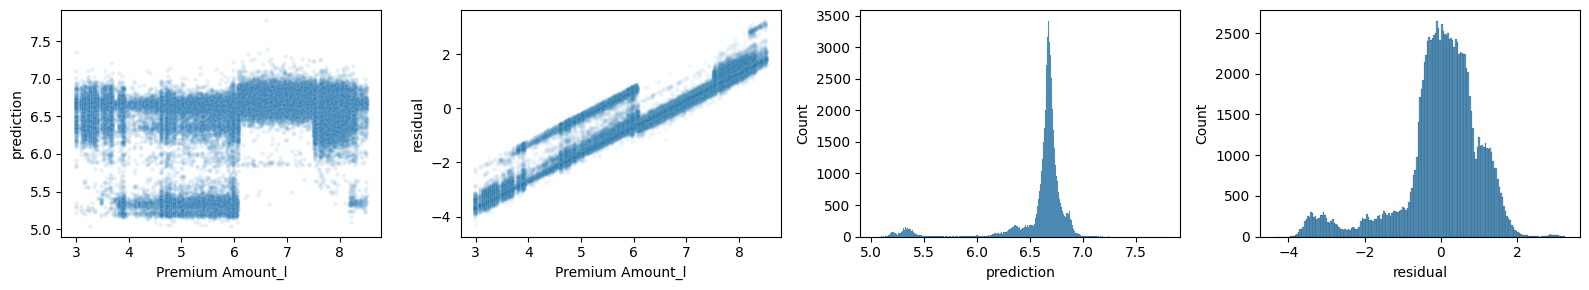

In [111]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

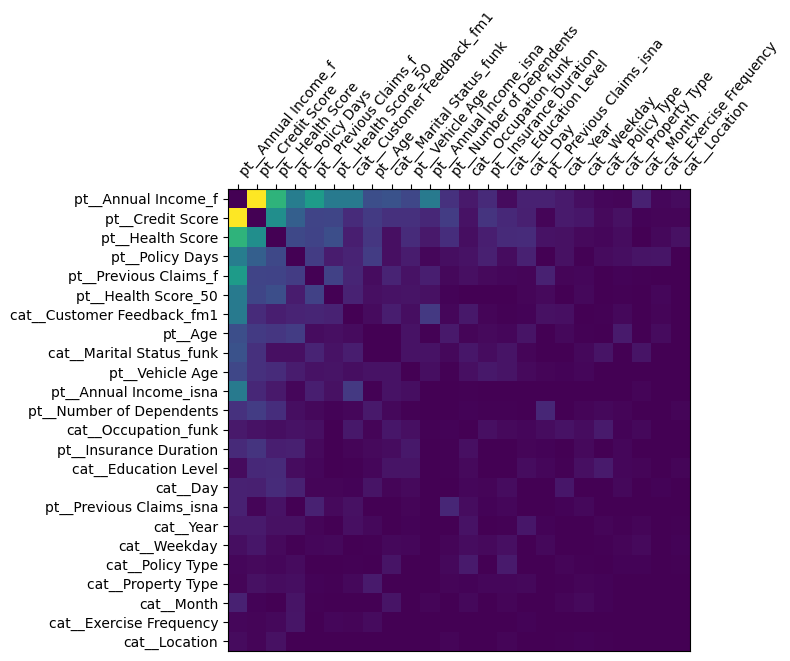

In [112]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## Credit Score

In [113]:
df_kruskal_cat.loc['Credit Score'].sort_values().to_frame().T

Year  Education Level     Month  Marital Status  \
Credit Score  6.198969e-17         0.000376  0.000433        0.000556   

                   Day  Smoking Status  Location  Customer Feedback  \
Credit Score  0.038657        0.069232  0.122319           0.310679   

              Policy Type    Gender   Weekday  Property Type  Occupation  \
Credit Score      0.35527  0.433204  0.578883       0.593443    0.631712   

              Exercise Frequency  
Credit Score            0.665591

In [114]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Credit Score'].sort_values(ascending = False).iloc[1:].to_frame().T

Previous Claims  Health Score  Policy Days       Age  \
Credit Score         0.036816      0.012016     0.006817  0.002842   

              Vehicle Age  Insurance Duration  Number of Dependents  \
Credit Score     0.000508            0.000493             -0.001714   

              Annual Income  
Credit Score      -0.201423

In [115]:
from sklearn.model_selection import cross_validate

X_C_cat = ['Marital Status_funk', 'Education Level', 'Year', 'Month']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_credit_score',
    lambda :
        df_train.loc[df_train['Credit Score'].notna()].pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Health Score_50']], x['Credit Score'], 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_C_cat}, return_train_score = True
            )
        )
    , rerun = False
)

{'fit_time': array([2.25454593, 2.36337805, 2.33198261, 2.41697478, 2.29186678]),
 'score_time': array([0.61116529, 0.67627788, 0.65597129, 0.66130519, 0.65922379]),
 'test_score': array([0.13196769, 0.13055185, 0.1313999 , 0.12919311, 0.13290811]),
 'train_score': array([0.13931132, 0.13950331, 0.13942564, 0.14017418, 0.13903013])}

In [116]:
reg_lgb = sc.cache_result(
    'lgb_credit_score_prd', 
    lambda :df_train.loc[df_train['Credit Score'].notna()].pipe(
        lambda x: reg_lgb.fit(x[X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Health Score_50']], x['Credit Score'])
    ), rerun = False
)
df_train['Credit Score_f'] = df_train['Credit Score']
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score_f'] = reg_lgb.predict(
    df_train.loc[df_train['Credit Score'].isna(), X_C_cat + ['Previous Claims', 'Health Score', 'Annual Income', 'Health Score_50']]
).astype('int')